In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

from google.colab import auth

auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [1]:
%cd drive

/content/drive


In [2]:
!pip3 install torchvision
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
!pip3 install torch


In [3]:
import torch.nn as nn
import math
import numpy as np
import torch.utils.model_zoo as model_zoo
import torch
from torch.autograd import Variable

__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, nb_classes=7, channel=20):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1_custom = nn.Conv2d(channel, 64, kernel_size=7, stride=2, padding=3,   
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7)
        self.fc_custom = nn.Linear(512 * block.expansion, nb_classes)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1_custom(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        out = self.fc_custom(x)
        return out


def resnet18(pretrained=False, channel= 20, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], nb_classes=101, channel=channel, **kwargs)
    if pretrained:
       pretrain_dict = model_zoo.load_url(model_urls['resnet18'])                  # modify pretrain code
       model_dict = model.state_dict()
       model_dict=weight_transform(model_dict, pretrain_dict, channel)
       model.load_state_dict(model_dict)
    return model


def resnet34(pretrained=False, channel= 20, **kwargs):

    model = ResNet(BasicBlock, [3, 4, 6, 3], nb_classes=7, channel=channel, **kwargs)
    if pretrained:
       pretrain_dict = model_zoo.load_url(model_urls['resnet34'])                  # modify pretrain code
       model_dict = model.state_dict()
       model_dict=weight_transform(model_dict, pretrain_dict, channel)
       model.load_state_dict(model_dict)
    return model


def resnet50(pretrained=False, channel= 20, **kwargs):

    model = ResNet(Bottleneck, [3, 4, 6, 3], nb_classes=7, channel=channel, **kwargs)
    if pretrained:
       pretrain_dict = model_zoo.load_url(model_urls['resnet50'])                  # modify pretrain code
       model_dict = model.state_dict()
       model_dict=weight_transform(model_dict, pretrain_dict, channel)
       model.load_state_dict(model_dict)
    return model


def resnet101(pretrained=False, channel= 20, **kwargs):

    model = ResNet(Bottleneck, [3, 4, 23, 3],nb_classes=7, channel=channel, **kwargs)
    if pretrained:
       pretrain_dict = model_zoo.load_url(model_urls['resnet101'])                  # modify pretrain code
       model_dict = model.state_dict()
       model_dict=weight_transform(model_dict, pretrain_dict, channel)
       model.load_state_dict(model_dict)

    return model


def resnet152(pretrained=False, **kwargs):

    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet152']))
    return model

def cross_modality_pretrain(conv1_weight, channel):
    # transform the original 3 channel weight to "channel" channel
    S=0
    for i in range(3):
        S += conv1_weight[:,i,:,:]
    avg = S/3.
    new_conv1_weight = torch.FloatTensor(64,channel,7,7)
    #print type(avg),type(new_conv1_weight)
    for i in range(channel):
        new_conv1_weight[:,i,:,:] = avg.data
    return new_conv1_weight

def weight_transform(model_dict, pretrain_dict, channel):
    weight_dict  = {k:v for k, v in pretrain_dict.items() if k in model_dict}
    #print pretrain_dict.keys()
    w3 = pretrain_dict['conv1.weight']
    #print type(w3)
    if channel == 3:
        wt = w3
    else:
        wt = cross_modality_pretrain(w3,channel)

    weight_dict['conv1_custom.weight'] = wt
    model_dict.update(weight_dict)
    return model_dict

#Test network
if __name__ == '__main__':
    model = resnet101(pretrained= True, channel=20)
    print(model)

ResNet(
  (conv1_custom): Conv2d (20, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d (64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv3): Conv2d (64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d (64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      )
    )


In [4]:
!ls

CIFAR-10	 dig_mnist		   MURA-v1.1
CIFAR.ipynb	 dog-breed-identification  MURA-v1.1(dataset)
Colab Notebooks  Getting started	   predict-future-sale
cycleGAN.ipynb	 HAR			   sop(kriti).odt
CycleGAN-master  HAR1


In [5]:
!pip install tqdm
!pip install visdom
!pip install git+https://github.com/pytorch/tnt.git@master


  Cloning https://github.com/pytorch/tnt.git (to revision master) to /tmp/pip-req-build-sqbw58rh
  Running setup.py bdist_wheel for torchnet ... - \ done
  Stored in directory: /tmp/pip-ephem-wheel-cache-o7mdhryk/wheels/17/05/ec/d05d051a225871af52bf504f5e8daf57704811b3c1850d0012
Successfully built torchnet


In [6]:
import numpy as np
import pickle
from PIL import Image
import time
import tqdm
import shutil
from random import randint
import keras

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms.functional as F


Using TensorFlow backend.


In [7]:
%cd HAR1

/content/drive/HAR1


In [0]:
import pandas as pd
labels = pd.read_csv('train.csv',index_col = 0)
#sample_submission = pd.read_csv(path + 'sample_submission.csv')

In [9]:
selected_labels = labels
selected_labels['label'] = selected_labels['label'].astype(int)
selected_labels['label'].dtype

dtype('int64')

In [0]:
from sklearn.model_selection import train_test_split
train_labels, valid_labels = train_test_split(selected_labels, test_size=0.3,shuffle=True) #test_split = 0.3


In [0]:
import math
import numpy as np
import pandas as pd
from IPython.display import FileLink
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
from torch.optim import lr_scheduler
import torch.utils.data
import torch.utils.data.distributed
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader

%matplotlib inline

In [0]:
transform = transforms.Compose([
            transforms.RandomHorizontalFlip(), # data augmentation: random horizontal flip
            #transforms.Scale(256),
            #transforms.CenterCrop(224),
            transforms.ToTensor(),
            #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

In [0]:
import torchvision.transforms.functional as F

class activityDataset(Dataset):
    def __init__(self, root_dir, labels, transform):
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        item = self.labels.iloc[idx]
        #print(item)
        path = self.root_dir + '/' + item['id']
        #print(item['id'])
        image = np.load(path)
        #print(image)

        if self.transform:
            image = F.to_pil_image(np.uint8(image))
            image = self.transform(image)
            
       
        #print(image,item['class'])
        
        return image, item['label']

In [0]:
t1 = activityDataset('data', train_labels, transform)
#t1[11]

In [102]:
modelres = model
modelres

ResNet(
  (conv1_custom): Conv2d (20, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d (64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv3): Conv2d (64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d (64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      )
    )


In [103]:
!pip install tensorboard_logger

In [0]:
batch_size = 64
train_dataset = activityDataset('data', train_labels, transform)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_dataset = activityDataset('data', valid_labels, transform)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True

)

In [105]:
! npm install -g localtunnel

/tools/node/bin/lt -> /tools/node/lib/node_modules/localtunnel/bin/client
+ localtunnel@1.9.0
updated 1 package in 2.912s


In [0]:
get_ipython().system_raw('/usr/local/bin/python -m pip install visdom')
get_ipython().system_raw('/usr/local/bin/python -m visdom.server -port 6007 >> visdomlog.txt 2>&1 &')
get_ipython().system_raw('lt --port 6007 >> url.txt 2>&1 &')


In [0]:
#import visdom
#visdom.Visdom(port='6009')
#! cat visdomlog.txt

In [0]:
import visdom
import time
import numpy as np

class Visualizer(object):
    '''
    orginal visdom API - self.vis.function
    '''

    def __init__(self, env='main', **kwargs):
        self.vis = visdom.Visdom(port='6007')
        
        # save（’loss',23）
        self.index = {} 
        self.log_text = ''
    
    def check_connection(self):
        return self.vis.check_connection()

    def plot(self, name, value,step=1,**kwargs):
        '''
        self.plot('loss',1.00)
        '''
        x = self.index.get(name, 0)
        self.vis.line(Y=np.array([value]), X=np.array([x]),
                      win=name,
                      opts=dict(title=name),
                      update=None if x == 0 else 'append',
                      **kwargs
                      )
        self.index[name] = x + step
        
    def plot_all(self, dict, step=1):
        '''
        plot multiple graphs
        @params d: dict (name,value) i.e. ('loss',0.11)
        '''
        for k, v in dict.items():
            self.plot(k, v, step)
            
    def plot_combine(self, name, d, step=1):
        #multiple plots in one single graph
        x = self.index.get(name, 0)
        X = []
        Y = []
        legend = []
        for k, v in sorted(d.items()):
            Y.append(v)
            X.append(x)
            legend.append(k)
        Y = np.array([Y])
        X = np.array([X])
        self.vis.line(
            Y=Y, 
            X=X,
            win=name,
            opts=dict(
                title=name,
                legend=legend
            ),
            update=None if x == 0 else 'append',
        )
        self.index[name] = x + step

    def img(self, name, img_,**kwargs):
        '''
        self.img('input_img',t.Tensor(64,64))
        self.img('input_imgs',t.Tensor(3,64,64))
        self.img('input_imgs',t.Tensor(100,1,64,64))
        self.img('input_imgs',t.Tensor(100,3,64,64),nrow=10)
        ！！！don‘t ~~self.img('input_imgs',t.Tensor(100,64,64),nrow=10)~~！！！
        '''
        self.vis.images(img_.cpu().numpy(),
                       win=name,
                       opts=dict(title=name),
                       **kwargs
                       )
                       
    def img_all(self, d):
        for k, v in d.iteritems():
            self.img(k, v)


    def log(self,info,name='log'):
        '''
        self.log({'loss':1,'lr':0.0001})
        '''

        self.log_text += ('[{time}] {info} <br>'.format(
                            time=time.strftime('%m%d_%H%M%S'),\
                            info=info)) 
        self.vis.text(self.log_text,name)   

    def __getattr__(self, name):
        return getattr(self.vis, name)
      
    def make_grid(I, ncols=8):
      assert isinstance(I, np.ndarray), 'plugin error, should pass numpy array here'
      assert I.ndim == 4 and I.shape[1] == 3
      nimg = I.shape[0]
      H = I.shape[2]
      W = I.shape[3]
      ncols = min(nimg, ncols)
      nrows = int(np.ceil(float(nimg) / ncols))
      canvas = np.zeros((3, H * nrows, W * ncols))
      i = 0
      for y in range(nrows):
        for x in range(ncols):
            if i >= nimg:
                break
            canvas[:, y * H:(y + 1) * H, x * W:(x + 1) * W] = I[i]
            i = i + 1
      return canvas


    def _prepare_image(I):
      # convert [N]CHW image to HWC
      assert isinstance(I, np.ndarray), 'plugin error, should pass numpy array here'
      assert I.ndim == 2 or I.ndim == 3 or I.ndim == 4
      if I.ndim == 4:  # NCHW
        if I.shape[1] == 1:  # N1HW
            I = np.concatenate((I, I, I), 1)  # N3HW
        assert I.shape[1] == 3
        I = make_grid(I)  # 3xHxW
      if I.ndim == 3 and I.shape[0] == 1:  # 1xHxW
        I = np.concatenate((I, I, I), 0)  # 3xHxW
      if I.ndim == 2:  # HxW
        I = np.expand_dims(I, 0)  # 1xHxW
        I = np.concatenate((I, I, I), 0)  # 3xHxW
      I = I.transpose(1, 2, 0)

      return I

      
    def prepare_numpy(x, modality):
      if modality == 'IMG':
        if x.dtype == np.uint8:
            x = x.astype(np.float32) / 255.0
        x = _prepare_image(x)
      if modality == 'VID':
        x = _prepare_video(x)
      return x


    def prepare_pytorch(x, modality):
      if isinstance(x, torch.autograd.Variable):
        x = x.data
      x = x.cpu().numpy()
      if modality == 'IMG':
        x = _prepare_image(x)
      if modality == 'VID':
        x = _prepare_video(x)
      return x
      
    def compute_curve(labels, predictions, num_thresholds=None, weights=None):
      _MINIMUM_COUNT = 1e-7

      if weights is None:
        weights = 1.0

      # Compute bins of true positives and false positives.
      bucket_indices = np.int32(np.floor(predictions * (num_thresholds - 1)))
      float_labels = labels.astype(np.float)
      histogram_range = (0, num_thresholds - 1)
      tp_buckets, _ = np.histogram(
        bucket_indices,
        bins=num_thresholds,
        range=histogram_range,
        weights=float_labels * weights)
      fp_buckets, _ = np.histogram(
        bucket_indices,
        bins=num_thresholds,
        range=histogram_range,
        weights=(1.0 - float_labels) * weights)

      # Obtain the reverse cumulative sum.
      tp = np.cumsum(tp_buckets[::-1])[::-1]
      fp = np.cumsum(fp_buckets[::-1])[::-1]
      tn = fp[0] - fp
      fn = tp[0] - tp
      precision = tp / np.maximum(_MINIMUM_COUNT, tp + fp)
      recall = tp / np.maximum(_MINIMUM_COUNT, tp + fn)
      return np.stack((tp, fp, tn, fn, precision, recall))

    def make_np(x, modality=None):
      if isinstance(x, np.ndarray):
        return prepare_numpy(x, modality)
      if isinstance(x, six.string_types):  # Caffe2 will pass name of blob(s) to fetch
        return prepare_caffe2(x, modality)
      if np.isscalar(x):
        return np.array([x])
      if 'torch' in str(type(x)):
        return prepare_pytorch(x, modality)
      if 'chainer' in str(type(x)):
        return prepare_chainer(x, modality)
      if 'mxnet' in str(type(x)):
        return prepare_mxnet(x, modality)

      
    def add_pr_curve(self, tag, labels, predictions, global_step=None, num_thresholds=127, weights=None):
        """Adds precision recall curve.
        Args:
        tag (string): Data identifier
            labels (torch.Tensor, numpy.array, or string/blobname): Ground truth data. Binary label for each element.
            predictions (torch.Tensor, numpy.array, or string/blobname):
            The probability that an element be classified as true. Value should in [0, 1]
            global_step (int): Global step value to record
            num_thresholds (int): Number of thresholds used to draw the curve.
        """
        labels, predictions = make_np(labels), make_np(predictions)
        raw_data = compute_curve(labels, predictions, num_thresholds, weights)

        # compute_curve returns np.stack((tp, fp, tn, fn, precision, recall))
        # We want to access 'precision' and 'recall'
        precision, recall = raw_data[4, :], raw_data[5, :]

        self.vis.line(
            X=recall,
            Y=precision,
            name=tag,
            opts={
                'title': 'PR Curve for {}'.format(tag),
                'xlabel': 'recall',
                'ylabel': 'precision',
            },
        )

    #@_check_connection
    def add_pr_curve_raw(self, tag, true_positive_counts,
                         false_positive_counts,
                         true_negative_counts,
                         false_negative_counts,
                         precision,
                         recall, global_step=None, num_thresholds=127, weights=None):
        """Adds precision recall curve with raw data.
        Args:
            tag (string): Data identifier
            true_positive_counts (torch.Tensor, numpy.array, or string/blobname): true positive counts
            false_positive_counts (torch.Tensor, numpy.array, or string/blobname): false positive counts
            true_negative_counts (torch.Tensor, numpy.array, or string/blobname): true negative counts
            false_negative_counts (torch.Tensor, numpy.array, or string/blobname): false negative counts
            precision (torch.Tensor, numpy.array, or string/blobname): precision
            recall (torch.Tensor, numpy.array, or string/blobname): recall
            global_step (int): Global step value to record
            num_thresholds (int): Number of thresholds used to draw the curve.
            see: https://github.com/tensorflow/tensorboard/blob/master/tensorboard/plugins/pr_curve/README.md
        """
        precision, recall = make_np(precision), make_np(recall)
        self.vis.line(
            X=recall,
            Y=precision,
            name=tag,
            opts={
                'title': 'PR Curve for {}'.format(tag),
                'xlabel': 'recall',
                'ylabel': 'precision',
            },
        )

In [109]:
! cat visdomlog.txt

It's Alive!
Traceback (most recent call last):
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/visdom/server.py", line 1159, in <module>
    download_scripts_and_run()
  File "/usr/local/lib/python2.7/dist-packages/visdom/server.py", line 1155, in download_scripts_and_run
    main()
  File "/usr/local/lib/python2.7/dist-packages/visdom/server.py", line 1150, in main
    print_func=print_func, user_credential=user_credential)
  File "/usr/local/lib/python2.7/dist-packages/visdom/server.py", line 1088, in start_server
    app.listen(port, max_buffer_size=1024 ** 3)
  File "/usr/local/lib/python2.7/dist-packages/tornado/web.py", line 1944, in listen
    server.listen(port, address)
  File "/usr/local/lib/python2.7/dist-packages/tornado/tcpserver.py", line 142, in listen
    sockets = bind_soc

In [110]:
#import time
#time.sleep(5)
! cat url.txt

your url is: https://jolly-firefox-29.localtunnel.me
/tools/node/lib/node_modules/localtunnel/bin/client:65
        throw err;
        ^

Error: connection refused: localtunnel.me:37482 (check your firewall settings)
    at Socket.<anonymous> (/tools/node/lib/node_modules/localtunnel/lib/TunnelCluster.js:47:32)
    at emitOne (events.js:116:13)
    at Socket.emit (events.js:211:7)
    at emitErrorNT (internal/streams/destroy.js:64:8)
    at _combinedTickCallback (internal/process/next_tick.js:138:11)
    at process._tickCallback (internal/process/next_tick.js:180:9)
/tools/node/lib/node_modules/localtunnel/bin/client:65
        throw err;
        ^

Error: connection refused: localtunnel.me:46453 (check your firewall settings)
    at Socket.<anonymous> (/tools/node/lib/node_modules/localtunnel/lib/TunnelCluster.js:47:32)
    at emitOne (events.js:116:13)
    at Socket.emit (events.js:211:7)
    at emitErrorNT (internal/streams/destroy.js:64:8)
    at _combinedTickCallback (internal/pro

In [111]:
!ls

data			      run_logs
datacombined.csv	      runs
ep200.h5		      SimpleHTTPServerWithUpload.py
meow			      Temporal_CNN.ipynb
model_best.pth.tar	      tensorboard_run.ipynb
ngrok			      test
ngrok-stable-linux-amd64.zip  test.csv
node_modules		      train
output			      train.csv
package (45127004).json       two-stream-action-recognition-master
package.json		      url.txt
run			      visdomlog.txt


In [0]:
vis = Visualizer()

In [113]:
!pip install git+https://github.com/pytorch/tnt.git@master


  Cloning https://github.com/pytorch/tnt.git (to revision master) to /tmp/pip-req-build-y7uhkzoc
  Running setup.py bdist_wheel for torchnet ... - \ done
  Stored in directory: /tmp/pip-ephem-wheel-cache-qc598kl5/wheels/17/05/ec/d05d051a225871af52bf504f5e8daf57704811b3c1850d0012
Successfully built torchnet


In [114]:
!ls 


data			      run_logs
datacombined.csv	      runs
ep200.h5		      SimpleHTTPServerWithUpload.py
meow			      Temporal_CNN.ipynb
model_best.pth.tar	      tensorboard_run.ipynb
ngrok			      test
ngrok-stable-linux-amd64.zip  test.csv
node_modules		      train
output			      train.csv
package (45127004).json       two-stream-action-recognition-master
package.json		      url.txt
run			      visdomlog.txt


In [0]:
import torchnet as tnt
from torchnet.engine import Engine
from torchnet.logger import VisdomPlotLogger, VisdomLogger

In [116]:
import os
import time
from torchnet.engine import Engine
from torchnet.logger import VisdomPlotLogger, VisdomLogger
import torchnet as tnt
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_curve,auc
#from sklearn.metrix import confusion_matrix
import numpy as np
#from tensorboard_logger import configure, log_value

confusion_matrix = tnt.meter.ConfusionMeter(7) #I have 7 classes here

def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    """Saves checkpoint to disk"""
    directory = "output/%s/"%('checkpoint')
    if not os.path.exists(directory):
        os.makedirs(directory)
    filename = directory + filename
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'output/%s/'%('checkpoint') + 'model_best1.pth.tar')
        
def main():
    #global prec1
    global best_prec1 
    #prec1=0
    #tensorboard = True
    epochs=300
    start_epoch=0
    batch_size=64
    lr=1e-1
    momentum=0.9
    weight_decay=1e-4
    print_freq=10
    layers=100
    growth=12
    droprate = 0.0
    reduce=0.5
    resume="" #"output/checkpoint/ccheckpoint (ecff0ae0).pth.tar"
    best_prec1 = 0 
    print_freq = 10
    global co
    co = 0
  
    #name = 'temporal_cnn'
    #global tensorboard,start_epoch
    #global best_prec1,start_epoch
    #configure("run_logs/%s"%(name))
    # create model
    model = modelres

    model = model.cuda()
   
    # optionally resume from a checkpoint
    if resume:
        if os.path.isfile(resume):
            print("=> loading checkpoint '{}'".format(resume))
            checkpoint = torch.load(resume)
            start_epoch = checkpoint['epoch']
            best_prec1 = checkpoint['best_prec1']
            model.load_state_dict(checkpoint['state_dict'])
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format(resume, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(resume))

    cudnn.benchmark = True

    # define loss function (criterion) and pptimizer
    criterion = nn.CrossEntropyLoss().cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr)
                                  
    for epoch in range(start_epoch, epochs):
        adjust_learning_rate(optimizer, epoch)
        co = co + 1
     
        # train for one epoch
      
        start_time = time.time()


        acc_train = train(train_loader, model, criterion, optimizer, epoch)

        # evaluate on validation set
        prec1 = validate(val_loader, model, criterion, epoch)
        print("--- %s seconds ---" % (time.time() - start_time))
        
        model_accuracy = {'Train_Acc':acc_train,
            'Val_Acc':prec1}
        
        vis.plot_combine("ACCURACY",model_accuracy)

        # remember best prec@1 and save checkpoint

        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)
        #print(best_prec1)
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
        }, is_best)
   #print('Best accuracy: ', best_prec1)
    
      

global predicted_label
global actual_label
predicted_label = []
actual_label = []
def train(train_loader, model, criterion, optimizer, epoch):
    """Train for one epoch on the training set"""

    print_freq = 10
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    
    num_elements = len(train_dataset)
    num_batches = len(train_loader)
    batch_size = train_loader.batch_size
    predictions = torch.zeros(num_elements)
    actual_label = torch.zeros(num_elements)
    confusion_matrix.reset()
    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):   
        
        target = target.cuda(async=True)
        input = input.cuda()
        input_var = torch.autograd.Variable(input)
        target_var = torch.autograd.Variable(target)

        # compute output
        output = model(input_var)            

        s = i*batch_size
        e = s + batch_size
        if i == num_batches - 1:
            e = num_elements
        _, preds = torch.max(output, dim=1)
        #print(":/",preds)
        predictions[s:e] = preds.data
        actual_label[s:e] = target_var.data
        
        loss = criterion(output, target_var)

        # measure accuracy and record loss
        prec1 = accuracy(output.data, target, topk=(1,))[0]
        losses.update(loss.data[0], input.size(0))
        top1.update(prec1[0], input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            #mlog.print_meter("Train", epoch, i, len(train_loader))  
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                      epoch, i, len(train_loader), batch_time=batch_time,
                      loss=losses, top1=top1))
    #print(predictions)
    #print("->",predictions)
    #print(list(np.asarray(predictions)))
    #print(list(np.asarray(predictions)+1))#,list(np.asarray(actual_label)+1))
    #print(np.array(list(np.asarray(predictions)+1)))
    #p = (np.array(list(pr)))
    #print(torch.from_numpy(p))
    if co not in [1,2,3,4,5,6]:
      vis.plot('Train_Loss',losses.avg)
    #confusion_matrix.add(torch.from_numpy(np.array(list(np.asarray(predictions)+1))),torch.from_numpy(np.array(list(np.asarray(actual_label)+1))))
    confusion_matrix.add(predictions,actual_label)
    precision, recall, fscore, support = score(Variable(actual_label).data.numpy(),Variable(predictions).data.numpy())
  
    #fpr, tpr, threshold = roc_curve(y_test, preds)
    #roc_auc = auc(fpr, tpr)
    

            
    pr = {
         'class-1':[precision[0],recall[0]],'class-2':[precision[1],recall[1]],'class-3':[precision[2],recall[2]],
         'class-4':[precision[3],recall[3]],'class-5':[precision[4],recall[4]],'class-6':[precision[5],recall[5]],'class-7':[precision[6],recall[6]]
         }
  
    #vis.plot_combine1('PR CURVE',pr)
    
    vis.heatmap(
        X=np.flipud(confusion_matrix.value()),
        opts=dict(
            columnnames=['class-7', 'class-6', 'class-5', 'class-4', 'class-3', 'class-2', 'class-1'],
            rownames=['class-7', 'class-6', 'class-5', 'class-4', 'class-3','class-2','class-1'],
            colormap='Electric',
        ),
        win = 'conf_train',
        env = 'main'
    )
   
    predictions = torch.zeros(num_elements)
    actual_label = torch.zeros(num_elements)
  
    return top1.avg

  
def validate(val_loader, model, criterion, epoch):
    print_freq = 10
    """Perform validation on the validation set"""
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    
    num_elements = len(val_dataset)
    num_batches = len(val_loader)
    batch_size = val_loader.batch_size
    predictions = torch.zeros(num_elements)
    actual_label = torch.zeros(num_elements)
    confusion_matrix.reset()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (input, target) in enumerate(val_loader):
        
        target = target.cuda(async=True)
        input = input.cuda()
        input_var = torch.autograd.Variable(input, volatile=True)
        target_var = torch.autograd.Variable(target, volatile=True)

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)
        
        s = i*batch_size
        e = s + batch_size
        if i == num_batches - 1:
            e = num_elements
        _, preds = torch.max(output, dim=1)
        predictions[s:e] = preds.data
        actual_label[s:e] = target_var.data
                

        # measure accuracy and record loss
        prec1 = accuracy(output.data, target, topk=(1,))[0]
        losses.update(loss.data[0], input.size(0))
        top1.update(prec1[0], input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        
        if i % print_freq == 0:
            print('Test: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                      i, len(val_loader), batch_time=batch_time, loss=losses,
                      top1=top1))
    if co not in [1,2,3,4,5,6]:
      vis.plot('Val_Loss',losses.avg)
    
    confusion_matrix.add(predictions,actual_label)
    
    precision, recall, fscore, support = score(Variable(actual_label).data.numpy(),Variable(predictions).data.numpy())
  
    #fpr, tpr, threshold = roc_curve(y_test, preds)
    #roc_auc = auc(fpr, tpr)
            
    pr = {
         'class-1':[precision[0],recall[0]],'class-2':[precision[1],recall[1]],'class-3':[precision[2],recall[2]],
         'class-4':[precision[3],recall[3]],'class-5':[precision[4],recall[4]],'class-6':[precision[5],recall[5]],'class-7':[precision[6],recall[6]]
         }

    #vis.plot_combine1('ye raha curve',pr)
    
    vis.heatmap(
        X=np.flipud(confusion_matrix.value()),
        opts=dict(
            columnnames=['class=7', 'class=6', 'class=5', 'class=4', 'class=3', 'class=2', 'class=1'],
            rownames=['class=7', 'class=6', 'class=5', 'class=4', 'class=3','class=2','class=1'],
            colormap='Electric',
        ),
        win = 'conf_val',
        env = 'main'
    )

    
    predictions = torch.zeros(num_elements)
    actual_label = torch.zeros(num_elements)

    # log to TensorBoard
    """if tensorboard:
        log_value('val_loss', losses.avg, epoch)
        log_value('val_acc', top1.avg, epoch)"""
    return top1.avg

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def adjust_learning_rate(optimizer, epoch):
    lr = 0.1
    """Sets the learning rate to the initial LR decayed by 10 after 150 and 225 epochs"""
    lr = lr * (0.1 ** (epoch // 150)) * (0.1 ** (epoch // 225))
    # log to TensorBoard
    """if tensorboard:
        log_value('learning_rate', lr, epoch)"""
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

if __name__ == '__main__':

  main()

RuntimeError: ignored

In [30]:
import os
from torchnet.engine import Engine
from torchnet.logger import VisdomPlotLogger, VisdomLogger
import torchnet as tnt
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_curve,auc
#from sklearn.metrix import confusion_matrix
import numpy as np
#from tensorboard_logger import configure, log_value
#from visdom import Visdom
#plotter = VisdomLinePlotter(env_name="HAR_PLOT")
#mlog = MeterLogger(server="localhost", port="6006", nclass=7,title="har_ConvNet")
confusion_matrix = tnt.meter.ConfusionMeter(7) #I have 2 classes here



def save_checkpoint(state, is_best, filename='checkpoint1.pth.tar'):
    """Saves checkpoint to disk"""
    directory = "output/%s/"%('checkpoint')
    if not os.path.exists(directory):
        os.makedirs(directory)
    filename = directory + filename
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'output/%s/'%('checkpoint') + 'model_best1.pth.tar')
        
def main():
    #global prec1
    global best_prec1 
    #prec1=0
    #tensorboard = True
    epochs=2
    start_epoch=0
    batch_size=128
    lr=1e-2
    momentum=0.9
    weight_decay=1e-4
    print_freq=10
    layers=100
    growth=12
    droprate = 0.0
    reduce=0.5
    resume="" #"output/checkpoint/ccheckpoint (ecff0ae0).pth.tar"
    best_prec1 = 0 
    print_freq = 10
  
    #name = 'temporal_cnn'
    #global tensorboard,start_epoch
    #global best_prec1,start_epoch
    #configure("run_logs/%s"%(name))
    # create model
    model = modelres

    model = model#.cuda()
   
    # optionally resume from a checkpoint
    if resume:
        if os.path.isfile(resume):
            print("=> loading checkpoint '{}'".format(resume))
            checkpoint = torch.load(resume)
            start_epoch = checkpoint['epoch']
            best_prec1 = checkpoint['best_prec1']
            model.load_state_dict(checkpoint['state_dict'])
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format(resume, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(resume))

    cudnn.benchmark = True

    # define loss function (criterion) and pptimizer
    criterion = nn.CrossEntropyLoss().cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr)
                                  
    for epoch in range(start_epoch, epochs):
        #adjust_learning_rate(optimizer, epoch)
     
        # train for one epoch
        train(train_loader, model, criterion, optimizer, epoch)

        # evaluate on validation set
        prec1 = validate(val_loader, model, criterion, epoch)
        #print("myprediction:",prec1)
        # remember best prec@1 and save checkpoint
        #print("prec1:",prec1)
        #print("best_prec1:",best_prec1)
        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)
        #print(best_prec1)
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
        }, is_best)
   #print('Best accuracy: ', best_prec1)
    
      

global predicted_label
global actual_label
predicted_label = []
actual_label = []
def train(train_loader, model, criterion, optimizer, epoch):
    """Train for one epoch on the training set"""

    print_freq = 10
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    
    num_elements = len(train_dataset)
    num_batches = len(train_loader)
    batch_size = train_loader.batch_size
    predictions = torch.zeros(num_elements)
    actual_label = torch.zeros(num_elements)
    confusion_matrix.reset()
    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):   
        
        target = target#.cuda(async=True)
        input = input#.cuda()
        input_var = torch.autograd.Variable(input)
        target_var = torch.autograd.Variable(target)
        # online ploter
        #mlog.timer.reset()

        # compute output
        output = model(input_var) 
        #print(output.data)
        #pred = output.data.max(1)[1] # get the index of the max log-probability
        #print(pred)
        #print(target_var.data)
        #correct += pred.eq(target.data).cpu().sum()
        #print(output.data)
        #confusion_matrix.add(output.data.squeeze(), target.type(t.LongTensor))
        #confusion_matrix.add(output.data, target_var.data)
        #actual_label.append(target_var.data)
        
        #print(actual_label.append((output.data.max(1)[1]).cpu()))
        #print((output.data.max(1)[1]))
        #print("ye lo:",torch.max(output, 1)[1])

        s = i*batch_size
        e = s + batch_size
        if i == num_batches - 1:
            e = num_elements
        #preds = output.data.max(1)[1]
        _, preds = torch.max(output, 1)
        predictions[s:e] = preds
        actual_label[s:e] = target_var.data
        
        loss = criterion(output, target_var)

        # measure accuracy and record loss
        prec1 = accuracy(output.data, target, topk=(1,))[0]
        losses.update(loss.data[0], input.size(0))
        top1.update(prec1[0], input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # online ploter
        #mlog.update_loss(loss, meter='loss')
	      #mlog.updateLoss(l1_loss, meter='l1_loss')
        #mlog.update_meter(output, target_var, meters={'accuracy', 'map'})

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            #mlog.print_meter("Train", epoch, i, len(train_loader))  
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                      epoch, i, len(train_loader), batch_time=batch_time,
                      loss=losses, top1=top1))
    loss = {'Train_Acc':top1.avg,
            'Train_Loss':losses.avg}
    vis.plot("Train_Acc",top1.avg)
    #vis.plot_combine("meow:",loss)
    #vis.plot_all(loss)
    
    
    #vis.add_pr_curve(self, tag, labels, predictions, global_step=None, num_thresholds=127, weights=None):

    #plotter.plot('acc', 'test', epoch, top1.avg)
    #plotter.plot('loss', 'test', epoch, losses.avg)
    # log to TensorBoard
    """if tensorboard:
        log_value('train_loss', losses.avg, epoch)
        log_value('train_acc', top1.avg, epoch)"""
        # online ploter
    #mlog.reset_meter(epoch, mode='Train')
    #print(confusion_matrix.conf)
    #print(predictions.size(0))
    print(predictions)
    confusion_matrix.add(predictions,actual_label)
    #print(confusion_matrix.conf)
    #print(actual_label)
    #print(Variable(actual_label).data.numpy())
    #compute_curve(Variable(actual_label).data.numpy(),Variable(predictions).data.numpy())
    
    precision, recall, fscore, support = score(Variable(actual_label).data.numpy(),Variable(predictions).data.numpy())
    #print('precision: {}'.format(precision))
    #print('recall: {}'.format(recall))
    #print('fscore: {}'.format(fscore))
    #print('support: {}'.format(support))   
    #fpr, tpr, threshold = roc_curve(y_test, preds)
    #roc_auc = auc(fpr, tpr)
   
    predictions = torch.zeros(num_elements)
    actual_label = torch.zeros(num_elements)

    
    return top1.avg

  
def validate(val_loader, model, criterion, epoch):
    print_freq = 10
    """Perform validation on the validation set"""
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (input, target) in enumerate(val_loader):
        
        target = target#.cuda(async=True)
        input = input#.cuda()
        input_var = torch.autograd.Variable(input, volatile=True)
        target_var = torch.autograd.Variable(target, volatile=True)

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # measure accuracy and record loss
        prec1 = accuracy(output.data, target, topk=(1,))[0]
        losses.update(loss.data[0], input.size(0))
        top1.update(prec1[0], input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        
        if i % print_freq == 0:
            print('Test: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                      i, len(val_loader), batch_time=batch_time, loss=losses,
                      top1=top1))
    """loss = {'Val_Acc':top1.avg,
            'Val_Loss':losses.avg}
    vis.plot_all(loss)"""
            
    #print(' * Prec@1 {top1.avg:.3f}'.format(top1=top1))
    #plotter.plot('acc', 'test', epoch, top1.avg)
    #plotter.plot('loss', 'test', epoch, losses.avg)
    # log to TensorBoard
    """if tensorboard:
        log_value('val_loss', losses.avg, epoch)
        log_value('val_acc', top1.avg, epoch)"""
    return top1.avg




class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def adjust_learning_rate(optimizer, epoch):
    lr = 0.1
    """Sets the learning rate to the initial LR decayed by 10 after 150 and 225 epochs"""
    lr = lr * (0.1 ** (epoch // 150)) * (0.1 ** (epoch // 225))
    # log to TensorBoard
    """if tensorboard:
        log_value('learning_rate', lr, epoch)"""
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

if __name__ == '__main__':

  main()

TypeError: ignored

In [0]:
!ls

In [0]:
! npm install -g localtunnel
get_ipython().system_raw('/usr/local/bin/python -m pip install visdom')
get_ipython().system_raw('/usr/local/bin/python -m visdom.server -port 6006 >> visdomlog.txt 2>&1 &')
get_ipython().system_raw('lt --port 6006 >> url.txt 2>&1 &')


/tools/node/bin/lt -> /tools/node/lib/node_modules/localtunnel/bin/client
+ localtunnel@1.9.0
updated 1 package in 2.119s


In [0]:
import time
time.sleep(5)
! cat url.txt


your url is: https://black-falcon-21.localtunnel.me
your url is: https://pretty-parrot-79.localtunnel.me
your url is: https://fluffy-hound-97.localtunnel.me
your url is: https://dull-insect-80.localtunnel.me
your url is: https://swift-goat-11.localtunnel.me
your url is: https://dangerous-snail-28.localtunnel.me
your url is: https://great-treefrog-55.localtunnel.me


In [0]:
import visdom
time.sleep(5)
vis = visdom.Visdom(port='6006')
print(vis)
time.sleep(3)
! cat visdomlog.txt



It's Alive!
Traceback (most recent call last):
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/visdom/server.py", line 1159, in <module>
    download_scripts_and_run()
  File "/usr/local/lib/python2.7/dist-packages/visdom/server.py", line 1155, in download_scripts_and_run
    main()
  File "/usr/local/lib/python2.7/dist-packages/visdom/server.py", line 1150, in main
    print_func=print_func, user_credential=user_credential)
  File "/usr/local/lib/python2.7/dist-packages/visdom/server.py", line 1088, in start_server
    app.listen(port, max_buffer_size=1024 ** 3)
  File "/usr/local/lib/python2.7/dist-packages/tornado/web.py", line 1944, in listen
    server.listen(port, address)
  File "/usr/local/lib/python2.7/dist-packages/tornado/tcpserver.py", line 142, in listen
    sockets = bind_soc

In [0]:
loss = {'Train_Acc':top1.avg,
            'Train_Loss':losses.avg}
vis.plot_combine('kuch bhi',loss)


NameError: ignored

In [0]:
data = [{
                'x':[1],
                'y':[4],
                
},{
                'x': [1],
                'y': [4],
                
}]

In [0]:
data = [{
                'x':[1,2,3],
                'y':[4,5,6],
                'marker':{
                        'color': 'red',
                        'symbol': 104,
                        'size': "10"},
                'mode':"markers+lines",
                'text':["one","two","three"],
                'name':'1st Trace',
                'type':'line',
},{
                'x': [1,2,3],
                'y': [4,5,6],
                'type': 'scatter',
                'mode': 'markers',
}]

win = 'mytestwin'
env = 'main'

layout= {
                'title':"Test Plot",
                'xaxis':{'title':'x1'},
                'yaxis':{'title':'x2'}
}
opts = {}

vis._send({'data': data, 'win': win, 'eid': env, 'layout': layout, 'opts': opts})


'mytestwin'

'window_36752079cdba5a'

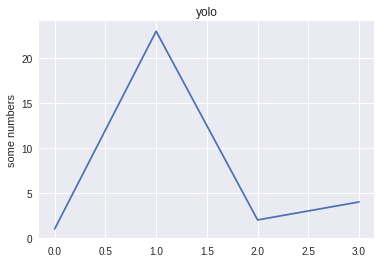

In [0]:
        import matplotlib.pyplot as plt
        plt.plot([1, 23, 2, 4])
        plt.title("yolo")
        plt.ylabel('some numbers')
        vis.matplot(plt)

In [0]:
    vis.heatmap(
        X=confusion_matrix.value(),
        opts=dict(
            columnnames=['a', 'b', 'c', 'd', 'e', 'f', 'g'],
            rownames=['y1', 'y2', 'y3', 'y4', 'y5','y6','y7'],
            colormap='Electric',
        )
    )

'window_3674858fd3abf2'

In [0]:
print(confusion_matrix.value())

[[ 9  0  0  9 12  0  5]
 [10  0  0 11 11  0  3]
 [ 8  0  0 11 11  1  6]
 [10  0  0 12  6  0  8]
 [12  0  0 10  6  0  7]
 [ 9  0  0 13  6  0  6]
 [18  0  0 15  8  0  1]]


In [0]:
for i in [1,2,3,4,5,6]:
  vis.plot("")

In [0]:
!ls

data		    run			   test.csv
datacombined.csv    run_logs		   train
ep200.h5	    runs		   train.csv
model_best.pth.tar  Temporal_CNN.ipynb	   two-stream-action-recognition-master
ngrok		    tensorboard_run.ipynb  url.txt
output		    test		   visdomlog.txt


In [0]:
import os
from tensorboard_logger import configure, log_value
def main():

    tensorboard = True
    epochs=300
    start_epoch=0
    batch_size=64
    lr=0.1
    momentum=0.9
    weight_decay=1e-4
    print_freq=10
    layers=100
    growth=12
    droprate = 0.0
    reduce=0.5
    resume=''
    best_prec1 = 0  
  
    #name = 'temporal_cnn'
    #global tensorboard,start_epoch
    #global best_prec1,start_epoch
    #configure("run_logs/%s"%(name))
    # create model
    model = modelres

    model = model.cuda()

    # optionally resume from a checkpoint
    if resume:
        if os.path.isfile(resume):
            print("=> loading checkpoint '{}'".format(resume))
            checkpoint = torch.load(resume)
            start_epoch = checkpoint['epoch']
            best_prec1 = checkpoint['best_prec1']
            model.load_state_dict(checkpoint['state_dict'])
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format(resume, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(resume))

    cudnn.benchmark = True

    # define loss function (criterion) and pptimizer
    criterion = nn.CrossEntropyLoss().cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr,
                                )
    
    for epoch in range(start_epoch, epochs):
        adjust_learning_rate(optimizer, epoch)
        prec1 = 0
        # train for one epoch
        train(train_loader, model, criterion, optimizer, epoch)

        # evaluate on validation set
        prec1 = validate(val_loader, model, criterion, epoch)

        # remember best prec@1 and save checkpoint
        #print("prec1:",prec1)
        #print("best_prec1:",best_prec1)
        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
        }, is_best)
    #print('Best accuracy: ', best_prec1)

def train(train_loader, model, criterion, optimizer, epoch):
    """Train for one epoch on the training set"""
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        target = target.cuda(async=True)
        input = input.cuda()
        input_var = torch.autograd.Variable(input)
        target_var = torch.autograd.Variable(target)

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # measure accuracy and record loss
        prec1 = accuracy(output.data, target, topk=(1,))[0]
        losses.update(loss.data[0], input.size(0))
        top1.update(prec1[0], input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                      epoch, i, len(train_loader), batch_time=batch_time,
                      loss=losses, top1=top1))
    # log to TensorBoard
    """if tensorboard:
        log_value('train_loss', losses.avg, epoch)
        log_value('train_acc', top1.avg, epoch)"""

def validate(val_loader, model, criterion, epoch):
    """Perform validation on the validation set"""
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (input, target) in enumerate(val_loader):
        target = target.cuda(async=True)
        input = input.cuda()
        input_var = torch.autograd.Variable(input, volatile=True)
        target_var = torch.autograd.Variable(target, volatile=True)

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # measure accuracy and record loss
        prec1 = accuracy(output.data, target, topk=(1,))[0]
        losses.update(loss.data[0], input.size(0))
        top1.update(prec1[0], input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            print('Test: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                      i, len(val_loader), batch_time=batch_time, loss=losses,
                      top1=top1))

    print(' * Prec@1 {top1.avg:.3f}'.format(top1=top1))
    # log to TensorBoard
    """if tensorboard:
        log_value('val_loss', losses.avg, epoch)
        log_value('val_acc', top1.avg, epoch)"""
    return top1.avg


def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    """Saves checkpoint to disk"""
    directory = "run_logs/%s/"%('checkpoint')
    if not os.path.exists(directory):
        os.makedirs(directory)
    filename = directory + filename
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'run_logs/%s/'%('checkpoint') + 'model_best.pth.tar')

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def adjust_learning_rate(optimizer, epoch):
    lr = 0.1
    """Sets the learning rate to the initial LR decayed by 10 after 150 and 225 epochs"""
    lr = lr * (0.1 ** (epoch // 150)) * (0.1 ** (epoch // 225))
    # log to TensorBoard
    if tensorboard:
        log_value('learning_rate', lr, epoch)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

if __name__ == '__main__':

  main()

RuntimeError: ignored

In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [0]:
import os 
import shutil 
import time

import torch 
from tensorboard_logger import log_value
#model, train, valid, optimizer, criterion, epochs=1, scheduler=None

def train(train_dataset, train_loader, model, criterion, optimizer, val_loader, checkpoint_directory, scheduler=None):
    """Train for one epoch on the training set"""
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    
    criterion = nn.CrossEntropyLoss().cuda()

    optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        if scheduler is not None:
            scheduler.batch_step()
        target = target.cuda(async=True)
        input = input.cuda()
        input_var = torch.autograd.Variable(input)
        target_var = torch.autograd.Variable(target)

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # measure accuracy and record loss
        prec1 = accuracy(output.data, target, topk=(1,))[0]
        losses.update(loss.data[0], input.size(0))
        top1.update(prec1[0], input.size(0))
        samples += input.size(0)


        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % args.print_freq == 0:
            print('Epoch: {0:.4f}\t'
                  'Step: {1}/{2}\t'
                  'Samples: [{samples}]\t'
                  'LR: {lr}\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Samples/s {samples_per_sec:.0f}\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                samples / len(train_dataset), i, len(train_loader), samples=samples, batch_time=batch_time,
                samples_per_sec=input.size(0)/batch_time.avg,
                lr=get_learning_rate(optimizer)[0],# *iter_accum ???
            loss=losses, top1=top1))

        if i % save_steps_freq == 0:
            if i>0:
                # evaluate on validation set
                prec1 = validate(val_loader, model, criterion, samples, args)

                # remember best prec@1 and save checkpoint
                print('Checkpoint')
                is_best = prec1 > best_prec1
                best_prec1 = max(prec1, best_prec1)
                is_best_train = top1.avg > best_train_prec1
                best_train_prec1 = max(top1.avg, best_train_prec1)
                save_checkpoint({
                    'samples': samples,
                    'state_dict': model.state_dict(),
                    'best_prec1': best_prec1,
                    'best_train_prec1': best_train_prec1,
                    'train_prec1': top1.avg,
                }, is_best, is_best_train,
                    directory=checkpoint_directory
                )

                # log to TensorBoard
                log_value('train_loss', losses.avg, samples)
                log_value('train_acc', top1.avg, samples)
                log_value('learning_rate', get_learning_rate(optimizer)[0], samples)
                log_value('batch_size', input.size(0), samples)
                log_value('effective_batch_size', input.size(0)*args.accum, samples)
                log_value('accum', args.accum, samples)

            batch_time.reset()
            losses.reset()
            top1.reset()
    return best_prec1, best_train_prec1, samples


def validate(val_loader, model, criterion, samples, args):
    """Perform validation on the validation set"""
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (input, target) in enumerate(val_loader):
        # print("input={}", input.size())
        target = target.cuda(async=True)
        input = input.cuda()
        input_var = torch.autograd.Variable(input, volatile=True)
        target_var = torch.autograd.Variable(target, volatile=True)

        # compute output
        output = model(input_var)
        # print("validate vars input={} target={} output={}".format(input_var.size(), target_var.size(), output.size()))
        loss = criterion(output, target_var)

        # measure accuracy and record loss
        prec1 = accuracy(output.data, target, topk=(1,))[0]
        losses.update(loss.data[0], input.size(0))
        top1.update(prec1[0], input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % args.print_freq == 0:
            print('Test: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                i, len(val_loader), batch_time=batch_time, loss=losses,
                top1=top1))

    print(' * Prec@1 {top1.avg:.3f}'.format(top1=top1))

    # log to TensorBoard
    log_value('val_loss', losses.avg, samples)
    log_value('val_acc', top1.avg, samples)

    return top1.avg


def save_checkpoint(state, is_best, is_best_train, directory, filename='checkpoint.pth.tar'):
    """Saves checkpoint to disk"""
    if not os.path.exists(directory):
        os.makedirs(directory)
    filename = directory + filename
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, directory + 'model_best.pth.tar')
    if is_best_train:
        shutil.copyfile(filename, directory + 'model_best_train.pth.tar')


class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def adjust_learning_rate(optimizer, epoch, lr):
    """Sets the learning rate to the initial LR decayed by 10 after 150 and 225 epochs"""
    lr = lr * (0.1 ** (epoch // 150)) * (0.1 ** (epoch // 225))
    # log to TensorBoard
    log_value('learning_rate', lr, epoch)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [0]:
train(model, train_loader, val_loader, optimizer, criterion, epochs=10) #, scheduler=scheduler)

In [0]:
def train(model, train, valid, optimizer, criterion, epochs=1, scheduler=None):
    for epoch in range(epochs):
        print('Epoch ', epoch + 1, '/', epochs)
        
        running_loss = 0.
        running_corrects = 0.
        running_batches = 0.

        if scheduler:
            scheduler.step()
            

            
        model = model.cuda()
    
        model.train()
        for i, (input, target) in enumerate(train):
            input = input.cuda()
            target = target.cuda()
            input_var = torch.autograd.Variable(input)
            target_var = torch.autograd.Variable(target)#.type(torch.LongTensor).cuda()

            optimizer.zero_grad()

            # compute output
            output = model(input_var)
            #print('output : ',output)
            #print('target:',target_var)
            _, preds = torch.max(output.data, 1)
            loss = criterion(output, target_var)

            loss.backward()
            optimizer.step()
            
            running_loss += loss.data[0]
            running_corrects += torch.sum(preds == target)
            running_batches += 1.

            print('\r', 'Batch', i, 'Loss', loss.data[0], end='')
            
        train_loss = running_loss / running_batches
        train_acc = running_corrects / len(train.dataset.labels)
        print('\r', "Train Loss", train_loss, "Train Accuracy", train_acc)
            
        running_loss = 0.
        running_corrects = 0.
        running_batches = 0.

        model.eval()
        for i, (input, target) in enumerate(valid):
            input = input.cuda()
            target = target.cuda()
            input_var = torch.autograd.Variable(input, volatile=True)
            target_var = torch.autograd.Variable(target, volatile=True)

            output = model(input_var)
            _, preds = torch.max(output.data, 1)
            loss = criterion(output, target_var)

            running_loss += loss.data[0]
            running_corrects += torch.sum(preds == target)
            running_batches += 1.

        valid_loss = running_loss / running_batches
        valid_acc = running_corrects / len(valid.dataset.labels)
        #print()
        print('\r', "Val Loss", valid_loss, "Val Accuracy", valid_acc)

In [0]:
import pickle,os
from PIL import Image
import scipy.io
import time
from tqdm import tqdm
import pandas as pd
import shutil
from random import randint
import numpy as np

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

# other util
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def save_checkpoint(state, is_best, checkpoint, model_best):
    torch.save(state, checkpoint)
    if is_best:
        shutil.copyfile(checkpoint, model_best)

def record_info(info,filename,mode):

    if mode =='train':

        result = (
              'Time {batch_time} '
              'Data {data_time} \n'
              'Loss {loss} '
              'Prec@1 {top1} '
              'Prec@5 {top5}\n'
              'LR {lr}\n'.format(batch_time=info['Batch Time'],
               data_time=info['Data Time'], loss=info['Loss'], top1=info['Prec@1'], top5=info['Prec@5'],lr=info['lr']))      
        print(result)

        df = pd.DataFrame.from_dict(info)
        column_names = ['Epoch','Batch Time','Data Time','Loss','Prec@1','Prec@5','lr']
        
    if mode =='test':
        result = (
              'Time {batch_time} \n'
              'Loss {loss} '
              'Prec@1 {top1} '
              'Prec@5 {top5} \n'.format( batch_time=info['Batch Time'],
               loss=info['Loss'], top1=info['Prec@1'], top5=info['Prec@5']))      
        print(result)
        df = pd.DataFrame.from_dict(info)
        column_names = ['Epoch','Batch Time','Loss','Prec@1','Prec@5']
    
    if not os.path.isfile(filename):
        df.to_csv(filename,index=False,columns=column_names)
    else: # else it exists so append without writing the header
        df.to_csv(filename,mode = 'a',header=False,index=False,columns=column_names)   

In [0]:
class Motion_CNN():
    def __init__(self, nb_epochs, lr, batch_size, resume, start_epoch, train_loader, test_loader, channel):
        self.nb_epochs=nb_epochs
        self.lr=lr
        self.batch_size=batch_size
        self.resume=resume
        self.start_epoch=start_epoch
        #self.evaluate=evaluate
        self.train_loader=train_loader
        self.test_loader=test_loader
        self.best_prec1=0
        self.channel=channel
        #self.test_video=test_video

    def build_model(self):
        print ('==> Build model and setup loss and optimizer')
        #build model
        self.model = modelres.cuda()
        #print self.model
        #Loss function and optimizer
        self.criterion = nn.CrossEntropyLoss().cuda()
        self.optimizer = torch.optim.SGD(self.model.parameters(), self.lr, momentum=0.9)
        self.scheduler = ReduceLROnPlateau(self.optimizer, 'min', patience=1,verbose=True)
        
        


    def resume_and_evaluate(self):
        if self.resume:
            if os.path.isfile(self.resume):
                print("==> loading checkpoint '{}'".format(self.resume))
                checkpoint = torch.load(self.resume)
                self.start_epoch = checkpoint['epoch']
                self.best_prec1 = checkpoint['best_prec1']
                self.model.load_state_dict(checkpoint['state_dict'])
                self.optimizer.load_state_dict(checkpoint['optimizer'])
                print("==> loaded checkpoint '{}' (epoch {}) (best_prec1 {})"
                  .format(self.resume, checkpoint['epoch'], self.best_prec1))
            else:
                print("==> no checkpoint found at '{}'".format(self.resume))

    
    def run(self):
        self.build_model()
        self.resume_and_evaluate()
        cudnn.benchmark = True
        
        for self.epoch in range(self.start_epoch, self.nb_epochs):
            self.train_1epoch()
            prec1, val_loss = self.validate_1epoch()
            is_best = prec1 > self.best_prec1
            #lr_scheduler
            self.scheduler.step(val_loss)
            # save model
            if is_best:
                self.best_prec1 = prec1
                with open('motion_video_preds.pickle','wb') as f:
                    pickle.dump(self.dic_video_level_preds,f)
                f.close() 
            
            save_checkpoint({
                'epoch': self.epoch,
                'state_dict': self.model.state_dict(),
                'best_prec1': self.best_prec1,
                'optimizer' : self.optimizer.state_dict()
            },is_best,'checkpoint.pth.tar','model_best.pth.tar')

    def train_1epoch(self):
        print('==> Epoch:[{0}/{1}][training stage]'.format(self.epoch, self.nb_epochs))

        batch_time = AverageMeter()
        data_time = AverageMeter()
        losses = AverageMeter()
        top1 = AverageMeter()
        top5 = AverageMeter()
        #switch to train mode
        self.model.train()    
        end = time.time()
        # mini-batch training
        progress = tqdm(self.train_loader)
        for i, (data,label) in enumerate(progress):

            # measure data loading time
            data_time.update(time.time() - end)
            
            label = label.cuda(async=True)
            input_var = Variable(data).cuda()
            target_var = Variable(label).cuda()

            # compute output
            output = self.model(input_var)
            loss = self.criterion(output, target_var)

            # measure accuracy and record loss
            prec1, prec5 = accuracy(output.data, label, topk=(1, 5))
            losses.update(loss.data[0], data.size(0))
            top1.update(prec1[0], data.size(0))
            top5.update(prec5[0], data.size(0))

            # compute gradient and do SGD step
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
        
        info = {'Epoch':[self.epoch],
                'Batch Time':[round(batch_time.avg,3)],
                'Data Time':[round(data_time.avg,3)],
                'Loss':[round(losses.avg,5)],
                'Prec@1':[round(top1.avg,4)],
                'Prec@5':[round(top5.avg,4)],
                'lr': self.optimizer.param_groups[0]['lr']
                }
        record_info(info, 'opf_train.csv','train')

    def validate_1epoch(self):
        print('==> Epoch:[{0}/{1}][validation stage]'.format(self.epoch, self.nb_epochs))

        batch_time = AverageMeter()
        losses = AverageMeter()
        top1 = AverageMeter()
        top5 = AverageMeter()
        # switch to evaluate mode
        self.model.eval()
        self.dic_video_level_preds={}
        end = time.time()
        progress = tqdm(self.test_loader)
        for i, (keys,data,label) in enumerate(progress):
            
            #data = data.sub_(127.353346189).div_(14.971742063)
            label = label.cuda(async=True)
            data_var = Variable(data, volatile=True).cuda(async=True)
            label_var = Variable(label, volatile=True).cuda(async=True)

            # compute output
            output = self.model(data_var)

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
            #Calculate video level prediction
            preds = output.data.cpu().numpy()
            nb_data = preds.shape[0]
            for j in range(nb_data):
                videoName = keys[j] # ApplyMakeup_g01_c01
                if videoName not in self.dic_video_level_preds.keys():
                    self.dic_video_level_preds[videoName] = preds[j,:]
                else:
                    self.dic_video_level_preds[videoName] += preds[j,:]
                    
        #Frame to video level accuracy
        video_top1, video_top5, video_loss = self.frame2_video_level_accuracy()
        info = {'Epoch':[self.epoch],
                'Batch Time':[round(batch_time.avg,3)],
                'Loss':[round(video_loss,5)],
                'Prec@1':[round(video_top1,3)],
                'Prec@5':[round(video_top5,3)]
                }
        record_info(info, 'opf_test.csv','test')
        return video_top1, video_loss

    def frame2_video_level_accuracy(self):
     
        correct = 0
        video_level_preds = np.zeros((len(self.dic_video_level_preds),101))
        video_level_labels = np.zeros(len(self.dic_video_level_preds))
        ii=0
        for key in sorted(self.dic_video_level_preds.keys()):
            name = key

            preds = self.dic_video_level_preds[name]
            label = int(self.test_video[name])-1
                
            video_level_preds[ii,:] = preds
            video_level_labels[ii] = label
            ii+=1         
            if np.argmax(preds) == (label):
                correct+=1

        #top1 top5
        video_level_labels = torch.from_numpy(video_level_labels).long()
        video_level_preds = torch.from_numpy(video_level_preds).float()

        loss = self.criterion(Variable(video_level_preds).cuda(), Variable(video_level_labels).cuda())    
        top1,top5 = accuracy(video_level_preds, video_level_labels, topk=(1,5))     
                            
        top1 = float(top1.numpy())
        top5 = float(top5.numpy())
            
        return top1,top5,loss.data.cpu().numpy()

In [0]:
    model = Motion_CNN(
                        # Data Loader
                        train_loader=train_loader,
                        test_loader=val_loader,
                        # Utility
                        start_epoch=start_epoch,
                        resume=resume,
                        #evaluate=arg.evaluate,
                        # Hyper-parameter
                        nb_epochs=epochs,
                        lr=lr,
                        batch_size=batch_size,
                        channel = 10*2,
                        #test_video=test_video
                        )
    #Training
    model.run()

==> Build model and setup loss and optimizer


RuntimeError: ignored

Epoch  1 / 10
 Train Loss 2.168302968144417 Train Accuracy 0.2047244094488189
 Val Loss 101.63469123840332 Val Accuracy 0.20909090909090908
Epoch  2 / 10
 Batch 3 Loss 2.1980788707733154

In [0]:
train_dataset = activityDataset('data', train_labels, transform)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size//2,
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    activityDataset('data', valid_labels, transform),
    batch_size=batch_size//2,
    shuffle=True
)

In [0]:
import pandas as pd
import numpy as np
train = pd.read_csv("train.csv",index_col = 0)
test =  pd.read_csv("test.csv",index_col=0)
#print (train.shape)
#print (test.shape)
train.reset_index()
test.reset_index()
train.index = range(train.shape[0])
test.index = range(test.shape[0])

#print(train.shape[0])   
target = train['label']
features = train.drop('label',axis=1)
X_data = features['id']
y_data = target


,id,label
0,Sit - stand up_Man4_002.npy,5.0
1,Hand-wave_Woman1_005.npy,1.0
2,Sit - stand up_Man6_002.npy,5.0
3,Jump-in-place_Woman2_001.npy,2.0
4,Bend_Man4_006.npy,0.0
5,Hand-wave_Man1_005.npy,1.0
6,Jump-in-place_Man2_003.npy,2.0
7,Pull_Man6_001.npy,3.0
8,Walk_Woman1_004.npy,6.0
9,Hand-wave_Man6_007.npy,1.0


In [0]:
dim = (216,216)
batch_size = X_data.shape[0]
n_classes = 7
n_channels = 20
shuffle = True
    
def data_generation(list_IDs_temp,labels):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((batch_size, *dim, n_channels))
        y = np.empty((batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            #print(i,ID)
            # Store sample
            X[i,] = np.load('data/' + ID )

            # Store class
            y[i] = labels[i]

        return X , keras.utils.to_categorical(y, num_classes=n_classes)

In [0]:
# Datasets
partition = X_data
labels =  y_data
#keras.utils.to_categorical(y, num_classes=n_classes)
# Generators
xData,yData = data_generation(partition,labels)

In [0]:
from sklearn.cross_validation import train_test_split
random_seed = 2
trainData, testData = train_test_split(xData, test_size=0.2,random_state=random_seed)
trainLabels, testLabels = train_test_split(labels, test_size=0.2,random_state=random_seed)

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [0]:
import numpy
images_batch = torch.from_numpy(trainData).float()
#images_batch = torch.from_numpy(numpy.array(trainData))
#images_batch = torch.stack([torch.Tensor(i) for i in trainData])
labels_batch = torch.from_numpy(numpy.array(trainLabels))


In [0]:
images_batch_val = torch.from_numpy(testData).float()
#images_batch_val = torch.from_numpy(numpy.array(testData))
#images_batch_val = torch.stack([torch.Tensor(i) for i in testData])
labels_batch_val = torch.from_numpy(numpy.array(testLabels))

In [0]:
train_dataset

NameError: ignored

In [0]:
train_dataset = images_batch,trainLabels
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)
val_dataset = images_batch_val , testLabels
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True
)

In [0]:
criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [0]:
loader = iter(train_loader)
next(loader)

KeyboardInterrupt: ignored

In [0]:
model = model.cuda()

In [0]:
train(model, train_loader, val_loader, optimizer, criterion, epochs=5) #, scheduler=scheduler)


Epoch  1 / 5


RuntimeError: ignored

In [0]:
def train(model, train, valid, optimizer, criterion, epochs=1, scheduler=None):
    for epoch in range(epochs):
        print('Epoch ', epoch + 1, '/', epochs)
        
        running_loss = 0.
        running_corrects = 0.
        running_batches = 0.

        if scheduler:
            scheduler.step()
            
        model.train()
        for i, (input, target) in enumerate(train):
            input = input.cuda()
            target = target.cuda()
            input_var = torch.autograd.Variable(input)
            target_var = torch.autograd.Variable(target)

            optimizer.zero_grad()

            # compute output
            output = model(input_var)
            _, preds = torch.max(output.data, 1)
            loss = criterion(output, target_var)

            loss.backward()
            optimizer.step()
            
            running_loss += loss.data[0]
            running_corrects += torch.sum(preds == target)
            running_batches += 1.

            print('\r', 'Batch', i, 'Loss', loss.data[0], end='')
            
        train_loss = running_loss / running_batches
        train_acc = running_corrects / len(train.dataset.labels)
        print('\r', "Train Loss", train_loss, "Train Accuracy", train_acc)
            
        running_loss = 0.
        running_corrects = 0.
        running_batches = 0.

        model.eval()
        for i, (input, target) in enumerate(valid):
            input = input.cuda()
            target = target.cuda()
            input_var = torch.autograd.Variable(input, volatile=True)
            target_var = torch.autograd.Variable(target, volatile=True)

            output = model(input_var)
            _, preds = torch.max(output.data, 1)
            loss = criterion(output, target_var)

            running_loss += loss.data[0]
            running_corrects += torch.sum(preds == target)
            running_batches += 1.

        valid_loss = running_loss / running_batches
        valid_acc = running_corrects / len(valid.dataset.labels)
        #print()
        print('\r', "Val Loss", valid_loss, "Val Accuracy", valid_acc)

In [0]:
#model = models.resnet34(pretrained= True, channel=10*2).cuda()
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, num_classes)
model = model.cuda()

criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.classifier.parameters()) #torch.optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)
#scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

AttributeError: ignored

In [0]:
train(model, train_loader, val_loader, optimizer, criterion, epochs=5) #, scheduler=scheduler)


In [0]:
loader = iter(train_loader)
next(loader)

AttributeError: ignored

In [0]:
import os

In [0]:
import pickle,os
from PIL import Image
import scipy.io
import time
from tqdm import tqdm
import pandas as pd
import shutil
from random import randint
import numpy as np

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

# other util
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def save_checkpoint(state, is_best, checkpoint, model_best):
    torch.save(state, checkpoint)
    if is_best:
        shutil.copyfile(checkpoint, model_best)

def record_info(info,filename,mode):

    if mode =='train':

        result = (
              'Time {batch_time} '
              'Data {data_time} \n'
              'Loss {loss} '
              'Prec@1 {top1} '
              'Prec@5 {top5}\n'
              'LR {lr}\n'.format(batch_time=info['Batch Time'],
               data_time=info['Data Time'], loss=info['Loss'], top1=info['Prec@1'], top5=info['Prec@5'],lr=info['lr']))      
        print(result)

        df = pd.DataFrame.from_dict(info)
        column_names = ['Epoch','Batch Time','Data Time','Loss','Prec@1','Prec@5','lr']
        
    if mode =='test':
        result = (
              'Time {batch_time} \n'
              'Loss {loss} '
              'Prec@1 {top1} '
              'Prec@5 {top5} \n'.format( batch_time=info['Batch Time'],
               loss=info['Loss'], top1=info['Prec@1'], top5=info['Prec@5']))      
        print(result)
        df = pd.DataFrame.from_dict(info)
        column_names = ['Epoch','Batch Time','Loss','Prec@1','Prec@5']
    
    if not os.path.isfile(filename):
        df.to_csv(filename,index=False,columns=column_names)
    else: # else it exists so append without writing the header
        df.to_csv(filename,mode = 'a',header=False,index=False,columns=column_names)   


In [0]:
class Motion_CNN():
    def __init__(self, nb_epochs, lr, batch_size, resume, start_epoch, train_loader, test_loader, channel):
        self.nb_epochs=nb_epochs
        self.lr=lr
        self.batch_size=batch_size
        self.resume=resume
        self.start_epoch=start_epoch
        #self.evaluate=evaluate
        self.train_loader=train_loader
        self.test_loader=test_loader
        self.best_prec1=0
        self.channel=channel
        #self.test_video=test_video

    def build_model(self):
        print ('==> Build model and setup loss and optimizer')
        #build model
        self.model = resnet34(pretrained= True, channel=self.channel).cuda()
        #print self.model
        #Loss function and optimizer
        self.criterion = nn.CrossEntropyLoss().cuda()
        self.optimizer = torch.optim.SGD(self.model.parameters(), self.lr, momentum=0.9)
        self.scheduler = ReduceLROnPlateau(self.optimizer, 'min', patience=1,verbose=True)
    '''def resume_and_evaluate(self):
        if self.resume:
            if os.path.isfile(self.resume):
                print("==> loading checkpoint '{}'".format(self.resume))
                checkpoint = torch.load(self.resume)
                self.start_epoch = checkpoint['epoch']
                self.best_prec1 = checkpoint['best_prec1']
                self.model.load_state_dict(checkpoint['state_dict'])
                self.optimizer.load_state_dict(checkpoint['optimizer'])
                print("==> loaded checkpoint '{}' (epoch {}) (best_prec1 {})"
                  .format(self.resume, checkpoint['epoch'], self.best_prec1))
            else:
                print("==> no checkpoint found at '{}'".format(self.resume))
        """if self.evaluate:
            self.epoch=0
            prec1, val_loss = self.validate_1epoch()
            return"""'''
          
    def run(self):
        self.build_model()
        #self.resume_and_evaluate()
        cudnn.benchmark = True
        
        for self.epoch in range(self.start_epoch, self.nb_epochs):
            self.train_1epoch()
            prec1, val_loss = self.validate_1epoch()
            is_best = prec1 > self.best_prec1
            #lr_scheduler
            self.scheduler.step(val_loss)
            # save model
            if is_best:
                self.best_prec1 = prec1
                with open('best_weight.pickle','wb') as f:
                    pickle.dump(self.dic_video_level_preds,f)
                f.close() 
            
            save_checkpoint({
                'epoch': self.epoch,
                'state_dict': self.model.state_dict(),
                'best_prec1': self.best_prec1,
                'optimizer' : self.optimizer.state_dict()
            },is_best,'checkpoint.pth.tar','model_best.pth.tar')

    def train_1epoch(self):
        print('==> Epoch:[{0}/{1}][training stage]'.format(self.epoch, self.nb_epochs))

        batch_time = AverageMeter()
        data_time = AverageMeter()
        losses = AverageMeter()
        top1 = AverageMeter()
        top5 = AverageMeter()
        #switch to train mode
        self.model.train()    
        end = time.time()
        # mini-batch training
        progress = tqdm(self.train_loader)
        print(progress)
        for i, (data,label) in enumerate(progress):

            # measure data loading time
            data_time.update(time.time() - end)
            
            label = label.cuda(async=True)
            input_var = Variable(data).cuda()
            target_var = Variable(label).cuda()

            # compute output
            output = self.model(input_var)
            loss = self.criterion(output, target_var)

            # measure accuracy and record loss
            prec1, prec5 = accuracy(output.data, label, topk=(1, 5))
            losses.update(loss.data[0], data.size(0))
            top1.update(prec1[0], data.size(0))
            top5.update(prec5[0], data.size(0))

            # compute gradient and do SGD step
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
        
        info = {'Epoch':[self.epoch],
                'Batch Time':[round(batch_time.avg,3)],
                'Data Time':[round(data_time.avg,3)],
                'Loss':[round(losses.avg,5)],
                'Prec@1':[round(top1.avg,4)],
                'Prec@5':[round(top5.avg,4)],
                'lr': self.optimizer.param_groups[0]['lr']
                }
        record_info(info, 'opf_train.csv','train')



In [0]:
    model = Motion_CNN(
                        # Data Loader
                        train_loader=train_loader,
                        test_loader=val_loader,
                        # Utility
                        start_epoch=start_epoch,
                        resume=resume,
                        #evaluate=evaluate,
                        # Hyper-parameter
                        nb_epochs=epochs,
                        lr=lr,
                        batch_size=batch_size,
                        channel = 10*2,
                        #test_video=test_video
                        )
    #Training
    model.run()

==> Build model and setup loss and optimizer



  0%|          | 0/1 [00:00<?, ?it/s]

==> Epoch:[0/500][training stage]
  0%|          | 0/1 [00:00<?, ?it/s]


RuntimeError: ignored

In [0]:
print(train_loader)

In [0]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, i=1, precision=3):
        self.meters = i
        self.precision = precision
        self.reset(self.meters)

    def reset(self, i):
        self.val = [0]*i
        self.avg = [0]*i
        self.sum = [0]*i
        self.count = 0

    def update(self, val, n=1):
        if not isinstance(val, list):
            val = [val]
        assert(len(val) == self.meters)
        self.count += n
        for i,v in enumerate(val):
            self.val[i] = v
            self.sum[i] += v * n
            self.avg[i] = self.sum[i] / self.count

    def __repr__(self):
        val = ' '.join(['{:.{}f}'.format(v, self.precision) for v in self.val])
        avg = ' '.join(['{:.{}f}'.format(a, self.precision) for a in self.avg])
        return '{} ({})'.format(val, avg)

In [0]:
    def validate_1epoch(self):
        print('==> Epoch:[{0}/{1}][validation stage]'.format(self.epoch, self.nb_epochs))

        batch_time = AverageMeter()
        losses = AverageMeter()
        top1 = AverageMeter()
        top5 = AverageMeter()
        # switch to evaluate mode
        self.model.eval()
        self.dic_video_level_preds={}
        end = time.time()
        progress = tqdm(self.test_loader)
        for i, (keys,data,label) in enumerate(progress):
            
            #data = data.sub_(127.353346189).div_(14.971742063)
            label = label.cuda(async=True)
            data_var = Variable(data, volatile=True).cuda(async=True)
            label_var = Variable(label, volatile=True).cuda(async=True)

            # compute output
            output = self.model(data_var)

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
            #Calculate video level prediction
            preds = output.data.cpu().numpy()
            nb_data = preds.shape[0]
            for j in range(nb_data):
                videoName = keys[j].split('-',1)[0] # ApplyMakeup_g01_c01
                if videoName not in self.dic_video_level_preds.keys():
                    self.dic_video_level_preds[videoName] = preds[j,:]
                else:
                    self.dic_video_level_preds[videoName] += preds[j,:]
                    
        #Frame to video level accuracy
        video_top1, video_top5, video_loss = self.frame2_video_level_accuracy()
        info = {'Epoch':[self.epoch],
                'Batch Time':[round(batch_time.avg,3)],
                'Loss':[round(video_loss,5)],
                'Prec@1':[round(video_top1,3)],
                'Prec@5':[round(video_top5,3)]
                }
        record_info(info, 'opf_test.csv','test')
        return video_top1, video_loss

    def frame2_video_level_accuracy(self):
     
        correct = 0
        video_level_preds = np.zeros((len(self.dic_video_level_preds),101))
        video_level_labels = np.zeros(len(self.dic_video_level_preds))
        ii=0
        for key in sorted(self.dic_video_level_preds.keys()):
            name = key.split('-',1)[0]

            preds = self.dic_video_level_preds[name]
            label = int(self.test_video[name])-1
                
            video_level_preds[ii,:] = preds
            video_level_labels[ii] = label
            ii+=1         
            if np.argmax(preds) == (label):
                correct+=1

        #top1 top5
        video_level_labels = torch.from_numpy(video_level_labels).long()
        video_level_preds = torch.from_numpy(video_level_preds).float()

        loss = self.criterion(Variable(video_level_preds).cuda(), Variable(video_level_labels).cuda())    
        top1,top5 = accuracy(video_level_preds, video_level_labels, topk=(1,5))     
                            
        top1 = float(top1.numpy())
        top5 = float(top5.numpy())
            
        return top1,top5,loss.data.cpu().numpy()

In [0]:
!pip install git+https://github.com/wookayin/tensorflow-plot.git@master

  Cloning https://github.com/wookayin/tensorflow-plot.git (to revision master) to /tmp/pip-req-build-9hwb4vo3
  Running setup.py bdist_wheel for tfplot ... - done
  Stored in directory: /tmp/pip-ephem-wheel-cache-dit9qetu/wheels/7a/90/54/0b41b5bd299f0d30f1d7eea21304d05ba171a4dfde98edd53e
Successfully built tfplot


In [0]:
import keras
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.models import Model
import os
from PIL import Image
from keras import optimizers
from sklearn.cross_validation import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
import tensorflow as tf
from textwrap import wrap
import itertools
import matplotlib
#import tfplot
import re
from keras.callbacks import Callback
run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)

from keras import backend as K
K.clear_session()

In [0]:
from keras.models import Sequential, load_model

from keras.layers.core import Dense, Dropout, Activation, Flatten

from keras.layers.convolutional import Conv2D, MaxPooling2D

In [0]:
def temporal_CNN(input_shape, classes, weights_dir, include_top=True):
        model = Sequential()



        #conv1

        model.add(Conv2D(128, (5, 5), strides=2, padding='same', input_shape=input_shape))

        model.add(BatchNormalization())

        model.add(Activation('relu'))

        model.add(MaxPooling2D(pool_size=(2, 2)))



        #conv2

        model.add(Conv2D(256, (5, 5), strides=2, padding='same'))

        model.add(Activation('relu'))

        model.add(MaxPooling2D(pool_size=(2, 2)))



        #conv3

        model.add(Conv2D(512, (3, 3), strides=1, activation='relu', padding='same'))



        #conv4

        model.add(Conv2D(512, (3, 3), strides=1, activation='relu', padding='same'))



        #conv5

        model.add(Conv2D(512, (3, 3), strides=1, activation='relu', padding='same'))

        model.add(MaxPooling2D(pool_size=(2, 2)))



        #full6

        model.add(Flatten())

        model.add(Dense(4096, activation='relu'))

        model.add(Dropout(0.9))



        #full7

        model.add(Dense(2048, activation='relu'))

        model.add(Dropout(0.9))



        #softmax

        model.add(Dense(7, activation='softmax'))

        return model

In [0]:
%cd HAR

/content/drive/HAR


In [0]:
!ls

data		  ngrok-stable-linux-amd64.zip	  test.csv	   url.txt
datacombined.csv  ngrok-stable-linux-amd64.zip.5  train
logs		  Temporal_CNN.ipynb		  train.csv
ngrok		  test				  Untitled0.ipynb


In [0]:
LOG_DIR = 'logs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)


In [0]:
! curl http://localhost:6006

curl: (7) Failed to connect to localhost port 6006: Connection refused


In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip > /dev/null 2>&1
! unzip ngrok-stable-linux-amd64.zip > /dev/null 2>&1

^C


In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib/python3.6/json/__init__.py", line 299, in load
    parse_constant=parse_constant, object_pairs_hook=object_pairs_hook, **kw)
  File "/usr/lib/python3.6/json/__init__.py", line 354, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.6/json/decoder.py", line 339, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/usr/lib/python3.6/json/decoder.py", line 357, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)


In [0]:
def temporal_CNN(input_shape, classes, weights_dir, include_top=True):
    '''
    The CNN for optical flow input.
    Since optical flow is not a common image, we cannot finetune pre-trained ResNet (The weights trained on imagenet is
    for images and thus is meaningless for optical flow)
    :param input_shape: the shape of optical flow input
    :param classes: number of classes
    :return:
    '''
    optical_flow_input = Input(shape=input_shape)

    x = Convolution2D(96, kernel_size=(7, 7), strides=(2, 2), padding='same', name='tmp_conv1')(optical_flow_input)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Convolution2D(256, kernel_size=(5, 5), strides=(2, 2), padding='same', name='tmp_conv2')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Convolution2D(512, kernel_size=(3, 3), strides=(2, 2), padding='same', name='tmp_conv3')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    x = Convolution2D(512, kernel_size=(3, 3), strides=(1, 1), padding='same', name='tmp_conv4')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    x = Convolution2D(512, kernel_size=(3, 3), strides=(1, 1), padding='same', name='tmp_conv5')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Flatten()(x)
    x = Dense(2048, activation='relu', name='tmp_fc6')(x)
    x = Dropout(0.9)(x)

    x = Dense(4096, activation='relu', name='tmp_fc7')(x)
    x = Dropout(0.9)(x)
   
    if include_top:
        x = Dense(classes, activation='softmax', name='tmp_fc101')(x)

    model = Model(inputs=optical_flow_input, outputs=x, name='temporal_CNN')
    
    if os.path.exists(weights_dir):
        
        model.load_weights(weights_dir, by_name=True)

    return model

In [0]:
if __name__ == '__main__':
    input_shape = (216, 216, 20)
    N_CLASSES = 7
    model = temporal_CNN(input_shape, N_CLASSES, weights_dir='')
    print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 216, 216, 20)      0         
_________________________________________________________________
tmp_conv1 (Conv2D)           (None, 108, 108, 96)      94176     
_________________________________________________________________
batch_normalization_1 (Batch (None, 108, 108, 96)      384       
_________________________________________________________________
activation_1 (Activation)    (None, 108, 108, 96)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 96)        0         
_________________________________________________________________
tmp_conv2 (Conv2D)           (None, 27, 27, 256)       614656    
_________________________________________________________________
batch_normalization_2 (Batch (None, 27, 27, 256)       1024      
__________

In [0]:
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
lr = 0.001
beta_1 = 0.9
beta_2 = 0.999
epsilon = 10 ** (-8)
optimizer = optimizers.Adam(lr=lr, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'],options = run_opts)

In [0]:
import pandas as pd
import numpy as np
train = pd.read_csv("train.csv",index_col = 0)
test =  pd.read_csv("test.csv",index_col=0)
#print (train.shape)
#print (test.shape)
train.reset_index()
test.reset_index()
train.index = range(train.shape[0])
test.index = range(test.shape[0])

#print(train.shape[0])   
target = train['label']
features = train.drop('label',axis=1)
X_data = features['id']
y_data = target


In [0]:
dim = (216,216)
batch_size = X_data.shape[0]
n_classes = 7
n_channels = 20
shuffle = True
    
def data_generation(list_IDs_temp,labels):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((batch_size, *dim, n_channels))
        y = np.empty((batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            #print(i,ID)
            # Store sample
            X[i,] = np.load('data/' + ID )

            # Store class
            y[i] = labels[i]

        return X , keras.utils.to_categorical(y, num_classes=n_classes)

In [0]:
!ls

data		  ngrok-stable-linux-amd64.zip	  test	     Untitled0.ipynb
datacombined.csv  ngrok-stable-linux-amd64.zip.1  test.csv   url.txt
logs		  ngrok-stable-linux-amd64.zip.5  train
ngrok		  Temporal_CNN.ipynb		  train.csv


In [0]:
# Datasets
partition = X_data
labels =  y_data
#keras.utils.to_categorical(y, num_classes=n_classes)
# Generators
xData,yData = data_generation(partition,labels)

In [0]:
random_seed = 2
trainData, testData = train_test_split(xData, test_size=0.2,random_state=random_seed)
trainLabels, testLabels = train_test_split(yData, test_size=0.2,random_state=random_seed)

In [0]:
trainData.shape,testData.shape

((291, 216, 216, 20), (73, 216, 216, 20))

In [0]:
class SensitivitySpecificityCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
      
        normalize=False
        title='Confusion matrix'
        tensor_name = 'image'
        session=tf.Session()   
        img_d_summary_dir = os.path.join('logs', "image")
        img_d_summary_writer = tf.summary.FileWriter(img_d_summary_dir, session.graph)
        x_test = self.validation_data[0]
        y_test = self.validation_data[1]
        #print(y_test)
        # x_test, y_test = self.validation_data
        predictions = self.model.predict(x_test)
        #print(predictions)
        y_test = np.argmax(y_test, axis=-1)
        predictions = np.argmax(predictions, axis=-1)
        #c = confusion_matrix(y_test, predictions)
        correct_labels = y_test
        predict_labels = predictions
        conf = tf.contrib.metrics.confusion_matrix(correct_labels, predict_labels)

        cm=session.run(conf)
        if normalize:
            cm = cm.astype('float')*10 / cm.sum(axis=1)[:, np.newaxis]
            cm = np.nan_to_num(cm, copy=True)
            cm = cm.astype('int')

        np.set_printoptions(precision=2)

        fig = matplotlib.figure.Figure(figsize=(7, 7), dpi=320, facecolor='w', edgecolor='k')
        ax = fig.add_subplot(1, 1, 1)
        im = ax.imshow(cm, cmap='Oranges')

        #classes = [re.sub(r'([a-z](?=[A-Z])|[A-Z](?=[A-Z][a-z]))', r'\1 ', x) for x in labels]
        #classes = ['\n'.join(wrap(l, 40)) for l in classes]
        classes = ['Bend','Hand-wave','Jump-in-place','Pull','Run','Sit-stand-up','Run']
        tick_marks = np.arange(len(classes))

        ax.set_xlabel('Predicted', fontsize=7)
        ax.set_xticks(tick_marks)
        c = ax.set_xticklabels(classes, fontsize=10, rotation=-90,  ha='center')
        ax.xaxis.set_label_position('bottom')
        ax.xaxis.tick_bottom()

        ax.set_ylabel('True Label', fontsize=7)
        ax.set_yticks(tick_marks)
        ax.set_yticklabels(classes, fontsize=10, va ='center')
        ax.yaxis.set_label_position('left')
        ax.yaxis.tick_left()

        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            ax.text(j, i, format(cm[i, j], 'd') if cm[i,j]!=0 else '.', horizontalalignment="center", fontsize=6, verticalalignment='center', color= "black")

        fig.set_tight_layout(True)
        summary = tfplot.figure.to_summary(fig, tag=tensor_name)
        img_d_summary_writer.add_summary(summary)
        img_d_summary_writer.flush()
        img_d_summary_writer.close()
        #return summary

In [0]:
class TrainValTensorBoard(TensorBoard):
    def __init__(self, log_dir='./logs', **kwargs):
        # Make the original `TensorBoard` log to a subdirectory 'training'
        training_log_dir = os.path.join(log_dir, 'training')
        super(TrainValTensorBoard, self).__init__(training_log_dir, **kwargs)
        
        # Log the validation metrics to a separate subdirectory
        self.val_log_dir = os.path.join(log_dir, 'validation')
        #self.img_d_summary_dir = os.path.join(log_dir, "image")

    def set_model(self, model):
        # Setup writer for validation metrics
        self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        #self.img_d_summary_writer = tf.summary.FileWriter(self.img_d_summary_dir)
        super(TrainValTensorBoard, self).set_model(model)

    def on_epoch_end(self, epoch, logs=None):
        # Pop the validation logs and handle them separately with
        # `self.val_writer`. Also rename the keys so that they can
        # be plotted on the same figure with the training metrics
        #img_d_summary =  TrainValTensorBoard.plot_confusion_matrix(correct_labels, predict_labels, labels, tensor_name='image')
        logs = logs or {}
        val_logs = {k.replace('val_', ''): v for k, v in logs.items() if k.startswith('val_')}
        for name, value in val_logs.items():
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.val_writer.add_summary(summary, epoch)
            #self.img_d_summary_writer.add_summary(img_d_summary, epoch)
        self.val_writer.flush()
        #self.img_d_summary_writer.flush()
        
        # Pass the remaining logs to `TensorBoard.on_epoch_end`
        logs = {k: v for k, v in logs.items() if not k.startswith('val_')}
        super(TrainValTensorBoard, self).on_epoch_end(epoch, logs)

    def on_train_end(self, logs=None):
        super(TrainValTensorBoard, self).on_train_end(logs)
        self.val_writer.close()
        

        


In [0]:
hist = model.fit(trainData,trainLabels, validation_data=(testData,testLabels),batch_size=32, epochs=100, callbacks=[SensitivitySpecificityCallback(),TrainValTensorBoard(write_graph=False)])#ConfusionMatrixPlotter])#TrainValTensorBoard(write_graph=False)])

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


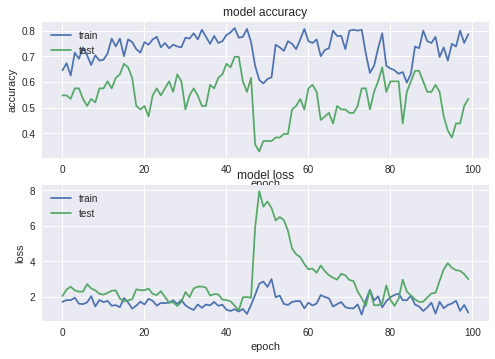

In [0]:
import matplotlib.pyplot as plt  
history = hist
print(history.history.keys())  
   
plt.figure(1)  
   
# summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
# summarize history for loss  
   
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()  

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


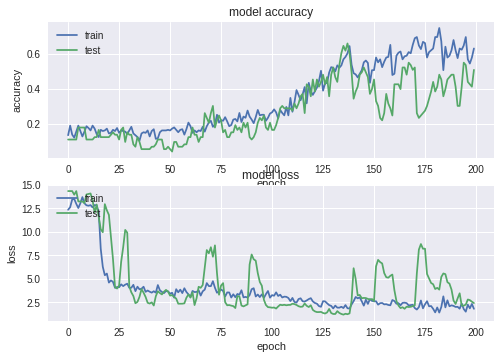

In [0]:
import matplotlib.pyplot as plt  
history = hist
print(history.history.keys())  
   
plt.figure(1)  
   
# summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
# summarize history for loss  
   
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()  

In [0]:
model.save_weights('ep200.h5')

In [0]:
hist = model.fit(trainData,trainLabels, validation_data=(testData,testLabels),batch_size=32, epochs=100, callbacks=[SensitivitySpecificityCallback(),TrainValTensorBoard(write_graph=False)])#ConfusionMatrixPlotter])#TrainValTensorBoard(write_graph=False)])

Train on 291 samples, validate on 73 samples
Epoch 1/100
291/291 [==============================] - 9s 29ms/step - loss: 10.9813 - acc: 0.1684 - val_loss: 13.2477 - val_acc: 0.1781
Epoch 2/100
291/291 [==============================] - 5s 18ms/step - loss: 12.4076 - acc: 0.1375 - val_loss: 11.8468 - val_acc: 0.2192
Epoch 3/100
291/291 [==============================] - 5s 17ms/step - loss: 11.1891 - acc: 0.1478 - val_loss: 11.9106 - val_acc: 0.2192
Epoch 4/100
291/291 [==============================] - 5s 17ms/step - loss: 7.9948 - acc: 0.1718 - val_loss: 9.8856 - val_acc: 0.1233
Epoch 5/100
291/291 [==============================] - 5s 17ms/step - loss: 6.3144 - acc: 0.1237 - val_loss: 5.8113 - val_acc: 0.0411
Epoch 6/100
291/291 [==============================] - 5s 17ms/step - loss: 4.6348 - acc: 0.1443 - val_loss: 5.9209 - val_acc: 0.0274
Epoch 7/100
291/291 [==============================] - 5s 17ms/step - loss: 4.7102 - acc: 0.1478 - val_loss: 6.7595 - val_acc: 0.0137
Epoch 8/100

291/291 [==============================] - 5s 17ms/step - loss: 3.8723 - acc: 0.1718 - val_loss: 3.6595 - val_acc: 0.1507
Epoch 13/100
291/291 [==============================] - 5s 17ms/step - loss: 3.6289 - acc: 0.2199 - val_loss: 3.9077 - val_acc: 0.1644
Epoch 14/100
291/291 [==============================] - 5s 17ms/step - loss: 3.4175 - acc: 0.2509 - val_loss: 5.3502 - val_acc: 0.1370
Epoch 15/100
291/291 [==============================] - 5s 17ms/step - loss: 3.7728 - acc: 0.2405 - val_loss: 11.4870 - val_acc: 0.1370
Epoch 16/100
291/291 [==============================] - 5s 17ms/step - loss: 3.5137 - acc: 0.2096 - val_loss: 11.3701 - val_acc: 0.1507
Epoch 17/100
291/291 [==============================] - 5s 17ms/step - loss: 3.1684 - acc: 0.2749 - val_loss: 13.9530 - val_acc: 0.0822
Epoch 18/100
291/291 [==============================] - 5s 17ms/step - loss: 3.5581 - acc: 0.2234 - val_loss: 13.4687 - val_acc: 0.1096
Epoch 19/100
291/291 [==============================] - 5s 17ms/

291/291 [==============================] - 5s 17ms/step - loss: 2.9368 - acc: 0.2784 - val_loss: 4.0723 - val_acc: 0.2603
Epoch 24/100
291/291 [==============================] - 5s 17ms/step - loss: 3.3428 - acc: 0.2440 - val_loss: 2.4592 - val_acc: 0.3288
Epoch 25/100
291/291 [==============================] - 5s 17ms/step - loss: 3.7789 - acc: 0.2818 - val_loss: 2.3431 - val_acc: 0.3288
Epoch 26/100
291/291 [==============================] - 5s 17ms/step - loss: 3.8152 - acc: 0.3058 - val_loss: 2.6971 - val_acc: 0.2740
Epoch 27/100
291/291 [==============================] - 5s 17ms/step - loss: 3.6986 - acc: 0.2646 - val_loss: 3.3632 - val_acc: 0.3014
Epoch 28/100
291/291 [==============================] - 5s 17ms/step - loss: 3.9077 - acc: 0.3058 - val_loss: 2.4248 - val_acc: 0.2740
Epoch 29/100
291/291 [==============================] - 5s 17ms/step - loss: 3.2916 - acc: 0.2921 - val_loss: 2.0695 - val_acc: 0.2329
Epoch 30/100
291/291 [==============================] - 5s 17ms/step

291/291 [==============================] - 5s 17ms/step - loss: 2.5706 - acc: 0.3608 - val_loss: 1.7812 - val_acc: 0.2603
Epoch 35/100
291/291 [==============================] - 5s 17ms/step - loss: 2.4173 - acc: 0.3677 - val_loss: 3.6269 - val_acc: 0.2329
Epoch 36/100
291/291 [==============================] - 5s 17ms/step - loss: 2.3797 - acc: 0.3368 - val_loss: 4.8061 - val_acc: 0.2329
Epoch 37/100
291/291 [==============================] - 5s 17ms/step - loss: 2.5628 - acc: 0.3162 - val_loss: 4.0169 - val_acc: 0.2877
Epoch 38/100
291/291 [==============================] - 5s 17ms/step - loss: 2.7401 - acc: 0.3471 - val_loss: 5.4365 - val_acc: 0.2192
Epoch 39/100
291/291 [==============================] - 5s 17ms/step - loss: 2.7433 - acc: 0.3162 - val_loss: 5.4435 - val_acc: 0.2055
Epoch 40/100
291/291 [==============================] - 5s 17ms/step - loss: 2.6627 - acc: 0.3814 - val_loss: 4.8304 - val_acc: 0.2329
Epoch 41/100
291/291 [==============================] - 5s 17ms/step

291/291 [==============================] - 5s 17ms/step - loss: 2.2654 - acc: 0.4399 - val_loss: 4.3514 - val_acc: 0.2603
Epoch 46/100
291/291 [==============================] - 5s 17ms/step - loss: 2.0656 - acc: 0.4089 - val_loss: 4.5544 - val_acc: 0.2192
Epoch 47/100
291/291 [==============================] - 5s 17ms/step - loss: 2.1794 - acc: 0.4502 - val_loss: 5.3414 - val_acc: 0.2329
Epoch 48/100
291/291 [==============================] - 5s 17ms/step - loss: 2.5278 - acc: 0.3849 - val_loss: 5.1192 - val_acc: 0.2055
Epoch 49/100
291/291 [==============================] - 5s 17ms/step - loss: 2.3763 - acc: 0.4021 - val_loss: 3.1261 - val_acc: 0.2603
Epoch 50/100
291/291 [==============================] - 5s 17ms/step - loss: 2.2556 - acc: 0.4433 - val_loss: 6.7368 - val_acc: 0.1918
Epoch 51/100
291/291 [==============================] - 5s 17ms/step - loss: 3.1956 - acc: 0.4021 - val_loss: 10.3754 - val_acc: 0.1096
Epoch 52/100
291/291 [==============================] - 5s 17ms/ste

291/291 [==============================] - 5s 17ms/step - loss: 3.3176 - acc: 0.3849 - val_loss: 14.7948 - val_acc: 0.0822
Epoch 57/100
291/291 [==============================] - 5s 17ms/step - loss: 3.2436 - acc: 0.3746 - val_loss: 14.8019 - val_acc: 0.0822
Epoch 58/100
291/291 [==============================] - 5s 17ms/step - loss: 3.0128 - acc: 0.3849 - val_loss: 14.7946 - val_acc: 0.0822
Epoch 59/100
291/291 [==============================] - 5s 17ms/step - loss: 2.8879 - acc: 0.4261 - val_loss: 14.7935 - val_acc: 0.0822
Epoch 60/100
291/291 [==============================] - 5s 17ms/step - loss: 3.2668 - acc: 0.4192 - val_loss: 14.7934 - val_acc: 0.0822
Epoch 61/100
291/291 [==============================] - 5s 17ms/step - loss: 3.0134 - acc: 0.4433 - val_loss: 14.7938 - val_acc: 0.0822
Epoch 62/100
291/291 [==============================] - 5s 17ms/step - loss: 3.2203 - acc: 0.4330 - val_loss: 14.7939 - val_acc: 0.0822
Epoch 63/100
291/291 [==============================] - 5s 17

291/291 [==============================] - 5s 18ms/step - loss: 2.6960 - acc: 0.4983 - val_loss: 11.4595 - val_acc: 0.1781
Epoch 68/100
291/291 [==============================] - 5s 17ms/step - loss: 2.4227 - acc: 0.5155 - val_loss: 11.0647 - val_acc: 0.1781
Epoch 69/100
291/291 [==============================] - 5s 17ms/step - loss: 2.4432 - acc: 0.5636 - val_loss: 10.7830 - val_acc: 0.1781
Epoch 70/100
291/291 [==============================] - 5s 17ms/step - loss: 2.4487 - acc: 0.5670 - val_loss: 10.7866 - val_acc: 0.1918
Epoch 71/100
291/291 [==============================] - 5s 17ms/step - loss: 2.2531 - acc: 0.6082 - val_loss: 8.3350 - val_acc: 0.2466
Epoch 72/100
291/291 [==============================] - 5s 17ms/step - loss: 2.5820 - acc: 0.4948 - val_loss: 6.4407 - val_acc: 0.2877
Epoch 73/100
291/291 [==============================] - 5s 17ms/step - loss: 1.8624 - acc: 0.5808 - val_loss: 3.3768 - val_acc: 0.3425
Epoch 74/100
291/291 [==============================] - 5s 17ms/

291/291 [==============================] - 5s 17ms/step - loss: 1.8790 - acc: 0.5911 - val_loss: 3.3464 - val_acc: 0.3699
Epoch 79/100
291/291 [==============================] - 5s 18ms/step - loss: 2.2456 - acc: 0.5361 - val_loss: 3.5708 - val_acc: 0.2740
Epoch 80/100
291/291 [==============================] - 5s 17ms/step - loss: 2.1524 - acc: 0.5292 - val_loss: 3.5226 - val_acc: 0.3014
Epoch 81/100
291/291 [==============================] - 5s 17ms/step - loss: 2.2325 - acc: 0.4914 - val_loss: 3.4183 - val_acc: 0.2603
Epoch 82/100
291/291 [==============================] - 5s 18ms/step - loss: 1.7903 - acc: 0.5808 - val_loss: 3.3017 - val_acc: 0.3151
Epoch 83/100
291/291 [==============================] - 5s 17ms/step - loss: 2.0238 - acc: 0.6220 - val_loss: 3.0483 - val_acc: 0.2877
Epoch 84/100
291/291 [==============================] - 5s 18ms/step - loss: 1.7480 - acc: 0.6289 - val_loss: 3.2459 - val_acc: 0.3699
Epoch 85/100
291/291 [==============================] - 5s 17ms/step

291/291 [==============================] - 5s 18ms/step - loss: 2.4259 - acc: 0.5670 - val_loss: 2.0792 - val_acc: 0.4247
Epoch 90/100
291/291 [==============================] - 5s 18ms/step - loss: 1.9091 - acc: 0.6014 - val_loss: 2.2350 - val_acc: 0.3562
Epoch 91/100
291/291 [==============================] - 5s 17ms/step - loss: 2.1613 - acc: 0.4914 - val_loss: 2.0653 - val_acc: 0.4384
Epoch 92/100
291/291 [==============================] - 5s 17ms/step - loss: 1.9742 - acc: 0.5361 - val_loss: 1.9767 - val_acc: 0.3836
Epoch 93/100
291/291 [==============================] - 5s 17ms/step - loss: 2.1106 - acc: 0.6117 - val_loss: 1.7178 - val_acc: 0.3699
Epoch 94/100
291/291 [==============================] - 5s 18ms/step - loss: 1.8978 - acc: 0.6357 - val_loss: 1.5590 - val_acc: 0.4658
Epoch 95/100
291/291 [==============================] - 5s 18ms/step - loss: 1.5721 - acc: 0.6873 - val_loss: 1.6524 - val_acc: 0.4247
Epoch 96/100
291/291 [==============================] - 5s 17ms/step

291/291 [==============================] - 5s 17ms/step - loss: 2.2574 - acc: 0.6598 - val_loss: 4.9826 - val_acc: 0.3699


In [0]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 32
gen = ImageDataGenerator(
        
        horizontal_flip= True
)

train_gen = gen.flow(trainData, trainLabels, batch_size=batch_size)
test_gen = gen.flow(testData, testLabels)

/usr/local/lib/python3.6/dist-packages/keras/preprocessing/image.py:1144: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (291, 216, 216, 20) (20 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')
/usr/local/lib/python3.6/dist-packages/keras/preprocessing/image.py:1144: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (73, 216, 216, 20) (20 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')


In [0]:
hist = model.fit(trainData,trainLabels, validation_data=(testData,testLabels),batch_size=32, epochs=100)

Train on 730 samples, validate on 82 samples
Epoch 1/100
730/730 [==============================] - 651s 891ms/step - loss: 0.8679 - acc: 0.6055 - val_loss: 1.0272 - val_acc: 0.6220
Epoch 2/100
730/730 [==============================] - 642s 879ms/step - loss: 0.8700 - acc: 0.6082 - val_loss: 0.9927 - val_acc: 0.6341
Epoch 3/100
730/730 [==============================] - 634s 869ms/step - loss: 0.8667 - acc: 0.6110 - val_loss: 0.9532 - val_acc: 0.6951
Epoch 4/100
730/730 [==============================] - 596s 816ms/step - loss: 0.8475 - acc: 0.5986 - val_loss: 1.0203 - val_acc: 0.7317
Epoch 5/100
730/730 [==============================] - 609s 834ms/step - loss: 0.8393 - acc: 0.6205 - val_loss: 1.0272 - val_acc: 0.7073
Epoch 6/100
730/730 [==============================] - 648s 887ms/step - loss: 0.8435 - acc: 0.6260 - val_loss: 1.0669 - val_acc: 0.7073
Epoch 7/100
730/730 [==============================] - 664s 910ms/step - loss: 0.8337 - acc: 0.6315 - val_loss: 1.0840 - val_acc: 0.7

KeyboardInterrupt: 

In [0]:
dim = (216,216)
batch_size = test.shape[0]
n_classes = 7
n_channels = 20
shuffle = True
    
def data_generation_test(list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((batch_size, *dim, n_channels))
        y = np.empty((batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            #print(i,ID)
            # Store sample
            X[i,] = np.load('F://data/' + ID)

           

        return X 

In [0]:
test_data = test['id']
print(test)
#test_data.shape
testData = data_generation_test(test_data)


                               id
0               Walk_Man1_003.npy
1      Jump-in-place_Man3_005.npy
2               Pull_Man4_004.npy
3     Sit - stand up_Man6_006.npy
4             Pull_Woman1_004.npy
5      Jump-in-place_Man4_007.npy
6      Jump-in-place_Man3_006.npy
7             Walk_Woman2_005.npy
8                Run_Man4_007.npy
9   Sit - stand up_Woman2_007.npy
10     Jump-in-place_Man5_000.npy
11         Hand-wave_Man3_002.npy
12    Sit - stand up_Man4_006.npy
13               Run_Man2_001.npy
14            Pull_Woman1_006.npy
15              Bend_Man6_000.npy
16       Hand-wave_Woman1_002.npy
17             Run_Woman1_002.npy
18               Run_Man5_006.npy
19              Walk_Man3_004.npy
20            Walk_Woman2_007.npy
21    Sit - stand up_Man2_004.npy
22    Sit - stand up_Man1_004.npy
23    Sit - stand up_Man2_006.npy
24             Run_Woman1_000.npy
25            Bend_Woman1_005.npy
26         Hand-wave_Man1_001.npy
27     Jump-in-place_Man1_002.npy
28  Sit - stan

FileNotFoundError: ignored

In [0]:
model.fit(trainData , trainLabels, validation_data=(testData , testLabels),batch_size=32, epochs=100) # ,callbacks=callbacks_list, verbose=0)

In [0]:
#filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
#checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#callbacks_list = [checkpoint]
# Fit the model
model.fit(train_gen, validation_data=(test_gen),batch_size=32, epochs=100) # ,callbacks=callbacks_list, verbose=0)

In [0]:
model.save_weights("ep300over.h5")

In [0]:
model.fit(trainData,trainLabels, validation_data=(testData,testLabels),batch_size=32, epochs=100, callbacks=[SensitivitySpecificityCallback(),TrainValTensorBoard(write_graph=False)])#ConfusionMatrixPlotter])#TrainValTensorBoard(write_graph=False)])

In [0]:
model.fit(trainData,trainLabels, validation_data=(testData,testLabels),batch_size=32, epochs=100, callbacks=[SensitivitySpecificityCallback(),TrainValTensorBoard(write_graph=False)])#ConfusionMatrixPlotter])#TrainValTensorBoard(write_graph=False)])

In [0]:
model.fit(trainData,trainLabels, validation_data=(testData,testLabels),batch_size=32, epochs=100, callbacks=[SensitivitySpecificityCallback(),TrainValTensorBoard(write_graph=False)])#ConfusionMatrixPlotter])#TrainValTensorBoard(write_graph=False)])

In [0]:
model.fit_generator(train_gen, steps_per_epoch=train_gen.n, epochs=100, validation_data=test_gen,validation_steps=test_gen.n,callbacks=[TrainValTensorBoard(write_graph=False)])

Epoch 1/100
291/291 [==============================] - 3009s 10s/step - loss: 13.7087 - acc: 0.1495 - val_loss: 14.3473 - val_acc: 0.1099
Epoch 2/100
 14/291 [>.............................] - ETA: 4:04:55 - loss: 13.7436 - acc: 0.1473

In [0]:
hist.history

{'val_loss': [16.11809539794922, 16.11809539794922],
 'val_acc': [0.0, 0.0],
 'loss': [12.08857157826424, 12.08857157826424],
 'acc': [0.25, 0.25]}

In [0]:
model.save_weights('ep108.h5')

In [0]:
pred = model.predict_classes(testData)

In [0]:
for i in pred:
    print(i)

1
1
1
1
0
0
1
1
0
0
0
0
0
0
0
0
